# Riparian Forest Data Analysis

This notebook analyzes riparian vegetation data from river sections in the Arve and Valserine basins.

**Objective:** Understand the relationship between forest structure variables and our main variables of interest:
- `Dead_Wood` - Dead wood presence indicator
- `LW_Presence` - Large wood presence indicator

## 1. Data Loading & Preparation

In [474]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skrub import TableReport

# Scikit-learn imports for later analysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Load the Excel file
df = pd.read_csv(r'C:\Users\jdelhoyo\PhD\Study cases\Genissiat\RV Characterization\repo-github\data\RV_For_RF4.csv')

# Remove Rhone basin to avoid contamination
df = df[df['Basin'] != 'Rhone'].copy()

print(f"Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Basins: {df['Basin'].unique()}")

Dataset shape: 78 rows × 32 columns
Basins: ['Arve' 'Valserine']


In [475]:
# Define column groups for analysis
ID_COLS = ['Id_RipUnit', 'Id_Reach', 'Basin', 'Sub_Basin', 'Reach', 'Bank', 'RipUnit']
TARGET_COLS = ['Dead_Wood', 'LW_Presence']
EXCLUDE_COLS = ['Lentgh (m)']  # River reach length - not relevant for forest structure analysis
DATA_COLS = [col for col in df.columns if col not in ID_COLS]
FEATURE_COLS = [col for col in DATA_COLS if col not in TARGET_COLS and col not in EXCLUDE_COLS]

print(f"ID columns ({len(ID_COLS)}): {ID_COLS}")
print(f"\nTarget variables: {TARGET_COLS}")
print(f"\nExcluded columns: {EXCLUDE_COLS}")
print(f"\nFeature columns ({len(FEATURE_COLS)}): {FEATURE_COLS}")

ID columns (7): ['Id_RipUnit', 'Id_Reach', 'Basin', 'Sub_Basin', 'Reach', 'Bank', 'RipUnit']

Target variables: ['Dead_Wood', 'LW_Presence']

Excluded columns: ['Lentgh (m)']

Feature columns (22): ['Sinuosity', 'Lat_Connectivity', 'Gradient (%)', 'SPI / Width', 'Standing_Dead_Trees', 'Regeneration', 'Basal_Area (m2/ha)', 'P50_Height', 'Height_IQR', 'Invasive_Ab', 'StructuralIndex', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31']


## 2. Data Overview & Profiling

Using skrub's `TableReport` for an interactive overview of the dataset.

In [476]:
# Interactive data profile with skrub
TableReport(df)

Processing column  32 / 32


<TableReport: use .open() to display>

In [477]:
# Data structure: samples per Basin and Sub_Basin
structure_summary = df.groupby(['Basin', 'Sub_Basin']).size().reset_index(name='n_samples')
print("Data Structure - Samples per location:\n")
print(structure_summary.to_string(index=False))

# Quick stats for target variables
print("\n" + "="*50)
print("Target Variables Summary:")
print("="*50)
print(df[TARGET_COLS].describe())

Data Structure - Samples per location:

    Basin Sub_Basin  n_samples
     Arve      Arve         34
     Arve    Giffre         16
     Arve    Menoge          6
Valserine    Semine          8
Valserine Valserine         14

Target Variables Summary:
       Dead_Wood  LW_Presence
count  78.000000    78.000000
mean    2.679487     2.551282
std     0.960162     0.948648
min     1.000000     1.000000
25%     2.000000     2.000000
50%     3.000000     2.000000
75%     3.000000     3.000000
max     4.000000     4.000000


## 3. Target Variable Distributions

Examining the distribution of our main variables of interest: `Dead_Wood` and `LW_Presence`.

C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_28300\2300281455.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 0].legend()
C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_28300\2300281455.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()


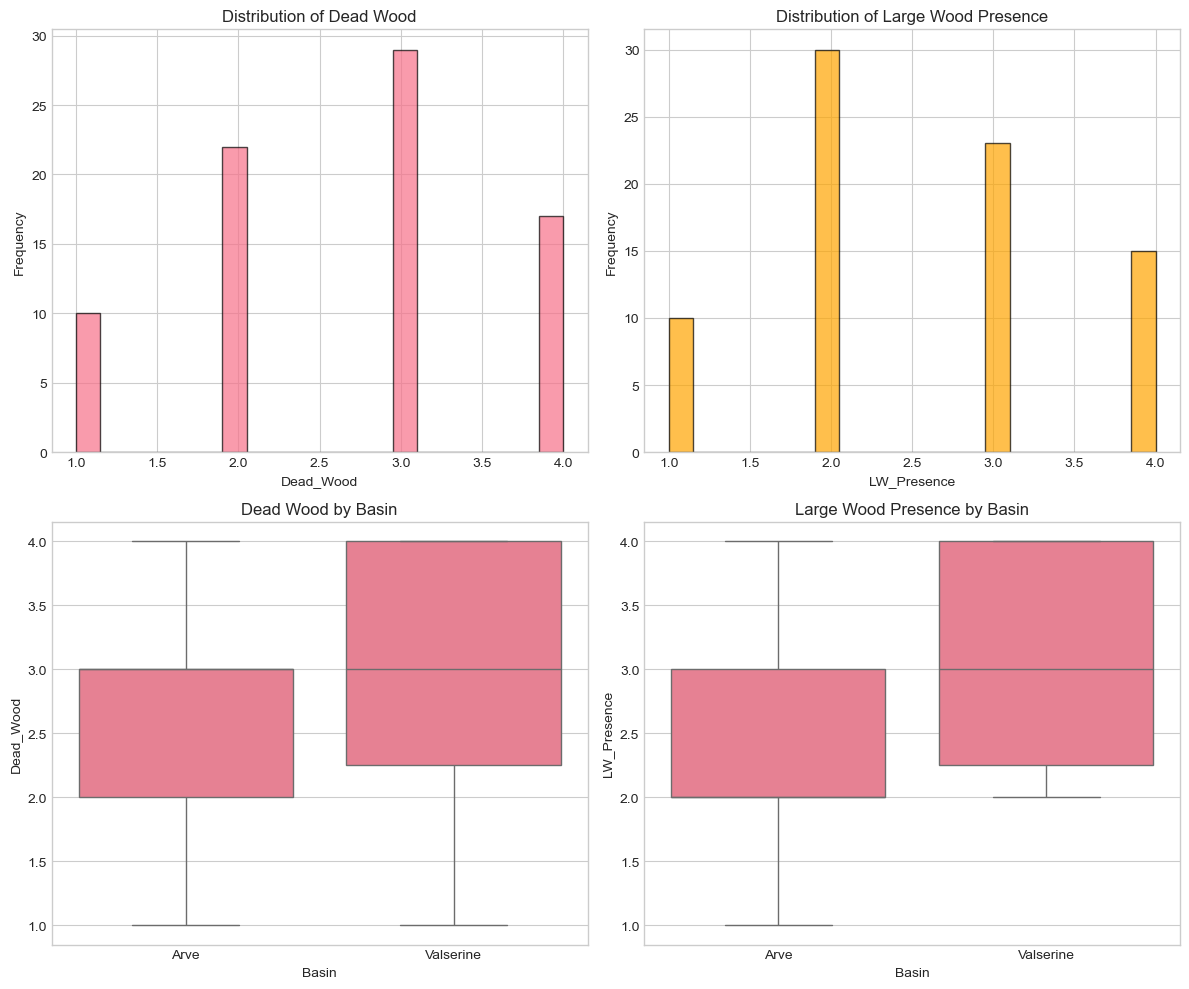

In [478]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Dead_Wood distribution
axes[0, 0].hist(df['Dead_Wood'].dropna(), bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Dead_Wood')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Dead Wood')
axes[0, 0].legend()

# LW_Presence distribution
axes[0, 1].hist(df['LW_Presence'].dropna(), bins=20, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('LW_Presence')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Large Wood Presence')
axes[0, 1].legend()

# Box plots by Basin
sns.boxplot(data=df, x='Basin', y='Dead_Wood', ax=axes[1, 0])
axes[1, 0].set_title('Dead Wood by Basin')

sns.boxplot(data=df, x='Basin', y='LW_Presence', ax=axes[1, 1])
axes[1, 1].set_title('Large Wood Presence by Basin')

plt.tight_layout()
plt.show()

## 4. Correlation Analysis

Analyzing relationships between all numeric variables and our target variables.

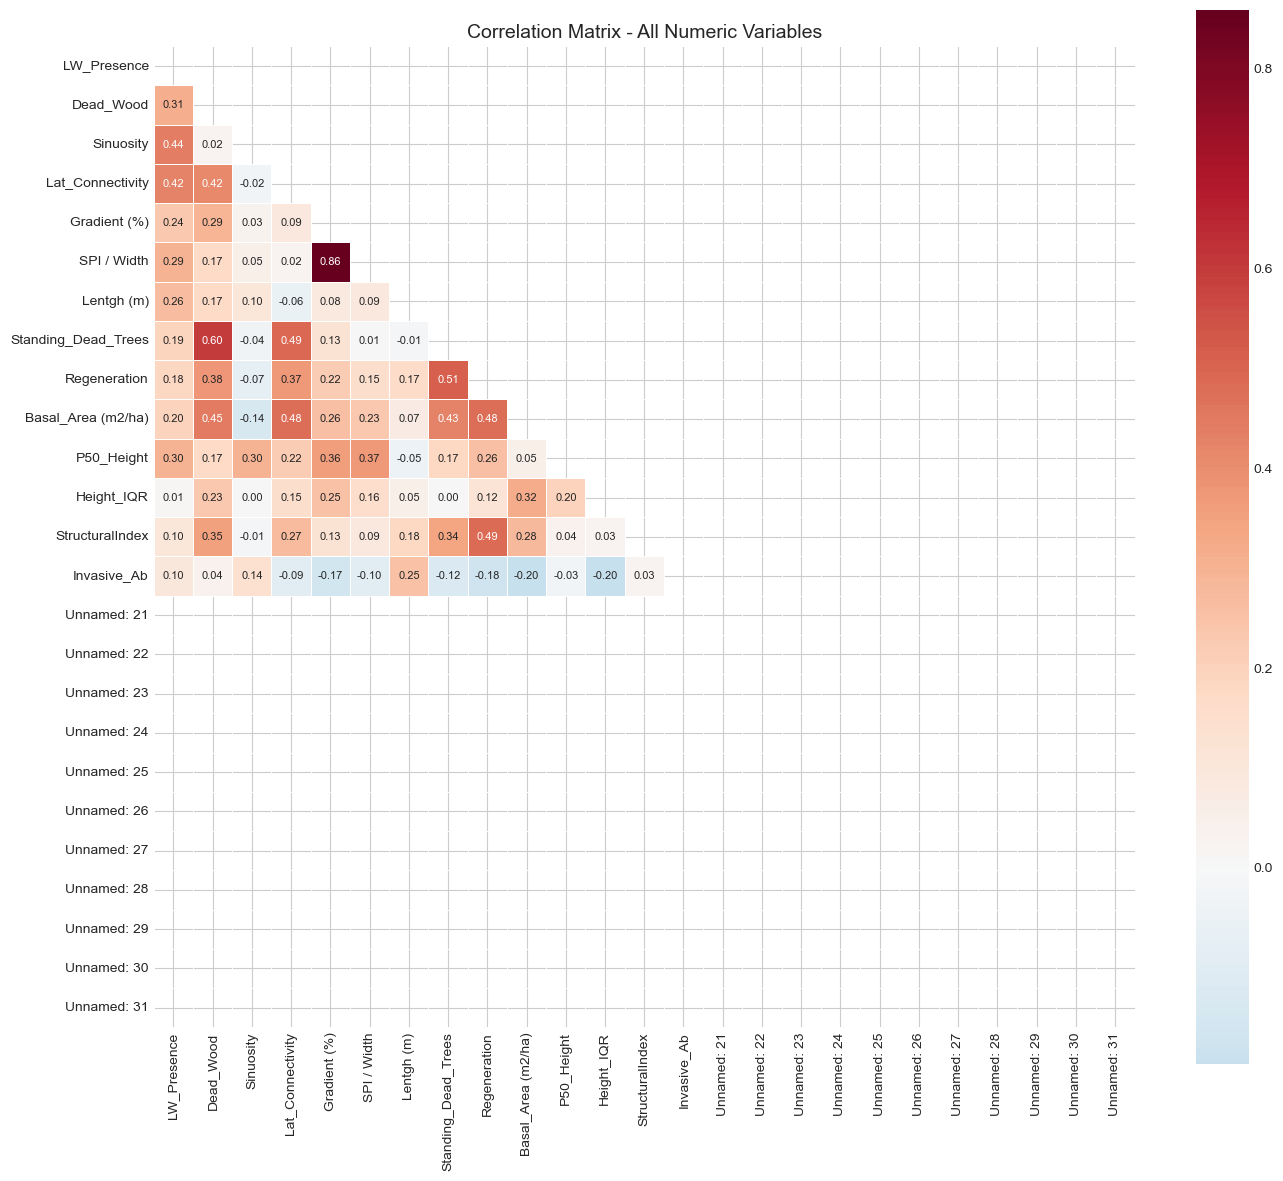

In [479]:
# Compute correlation matrix for all numeric columns
numeric_df = df[DATA_COLS].select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Define desired column order (targets first, then others as specified in the reference image)
# Include only columns that actually exist in the dataframe
desired_order = [
    'LW_Presence', 'Dead_Wood',  # Target variables first
    'Sinuosity', 'Width_Mean', 'Lat_Connectivity', 'Gradient (%)', 'SPI / Width', 'SPI', 'Lentgh (m)',
    'Standing_Dead_Trees', 'Regeneration', 'Basal_Area (m2/ha)', 'P50_Height',  'Height_IQR', 
    'StructuralIndex', 'HardWood_Ab', 'SoftWood_Ab', 'Pioneers_Ab', 'Shrubs_Ab', 
    'Brambles_Ab', 'Invasive_Ab', 'MaxDiamClass', 'DiamComplex', 
    'SizeSkewness', 
]

# Filter to only include columns that exist in the correlation matrix
available_cols = [col for col in desired_order if col in corr_matrix.columns]
# Add any remaining columns not in the desired order (in case there are extras)
remaining_cols = [col for col in corr_matrix.columns if col not in available_cols]
col_order = available_cols + remaining_cols

# Reorder the correlation matrix
corr_matrix_ordered = corr_matrix.loc[col_order, col_order]

# Full correlation heatmap
fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix_ordered, dtype=bool))  # Upper triangle mask
sns.heatmap(corr_matrix_ordered, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, square=True, linewidths=0.5, ax=ax,
            annot_kws={'size': 8})
ax.set_title('Correlation Matrix - All Numeric Variables', fontsize=14)
plt.tight_layout()
plt.show()

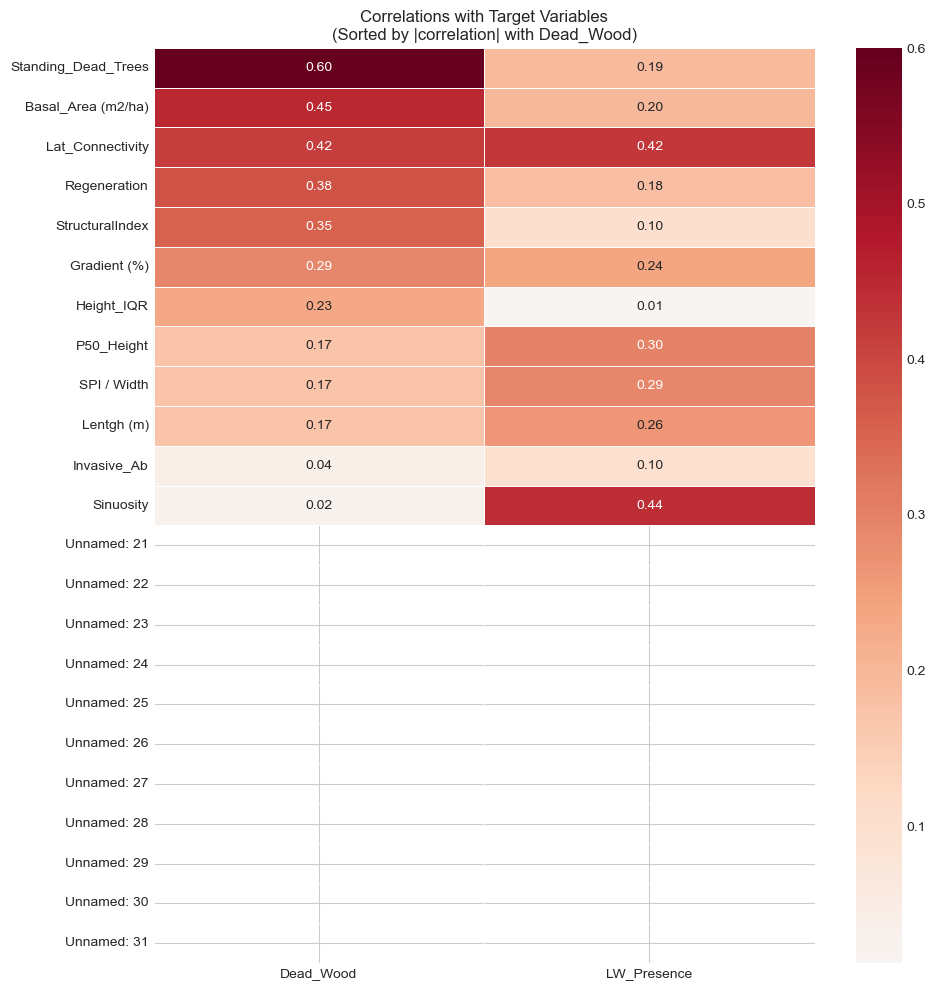

Top 5 correlates with Dead_Wood:
  Standing_Dead_Trees: 0.600
  Basal_Area (m2/ha): 0.449
  Lat_Connectivity: 0.416
  Regeneration: 0.380
  StructuralIndex: 0.352

Top 5 correlates with LW_Presence:
  Sinuosity: 0.439
  Lat_Connectivity: 0.424
  P50_Height: 0.296
  SPI / Width: 0.294
  Lentgh (m): 0.262


In [480]:
# Focus on correlations with target variables
target_corr = corr_matrix[TARGET_COLS].drop(TARGET_COLS)
target_corr = target_corr.reindex(target_corr['Dead_Wood'].abs().sort_values(ascending=False).index)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(target_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            linewidths=0.5, ax=ax, annot_kws={'size': 10})
ax.set_title('Correlations with Target Variables\n(Sorted by |correlation| with Dead_Wood)', fontsize=12)
plt.tight_layout()
plt.show()

# Print top correlates
print("Top 5 correlates with Dead_Wood:")
for var, val in target_corr['Dead_Wood'].head().items():
    print(f"  {var}: {val:.3f}")
    
print("\nTop 5 correlates with LW_Presence:")
for var, val in target_corr['LW_Presence'].abs().sort_values(ascending=False).head().items():
    corr_val = target_corr.loc[var, 'LW_Presence']
    print(f"  {var}: {corr_val:.3f}")

## 5. Scatter Plots - Key Relationships

This section visualizes how each of the **top correlated features** relates to our target variables (`Dead_Wood` and `LW_Presence`).

**How to read these plots:**
- **Top row:** Relationship of each feature with `Dead_Wood`
- **Bottom row:** Relationship of each feature with `LW_Presence`
- **Marker shape:** 
  - **Left half-circle** = Arve basin (purple)
  - **Right half-circle** = Valserine basin (yellow)
- **Point size:** For discrete variables, the size of each half-circle is proportional to the frequency of that (x, y) combination **within its own basin**. This allows visual comparison of relative frequencies between basins at the same data point.
- **r value:** Pearson correlation coefficient displayed in each subplot title

A higher absolute |r| indicates a stronger linear relationship. Positive r means the variables increase together; negative r means they move in opposite directions.

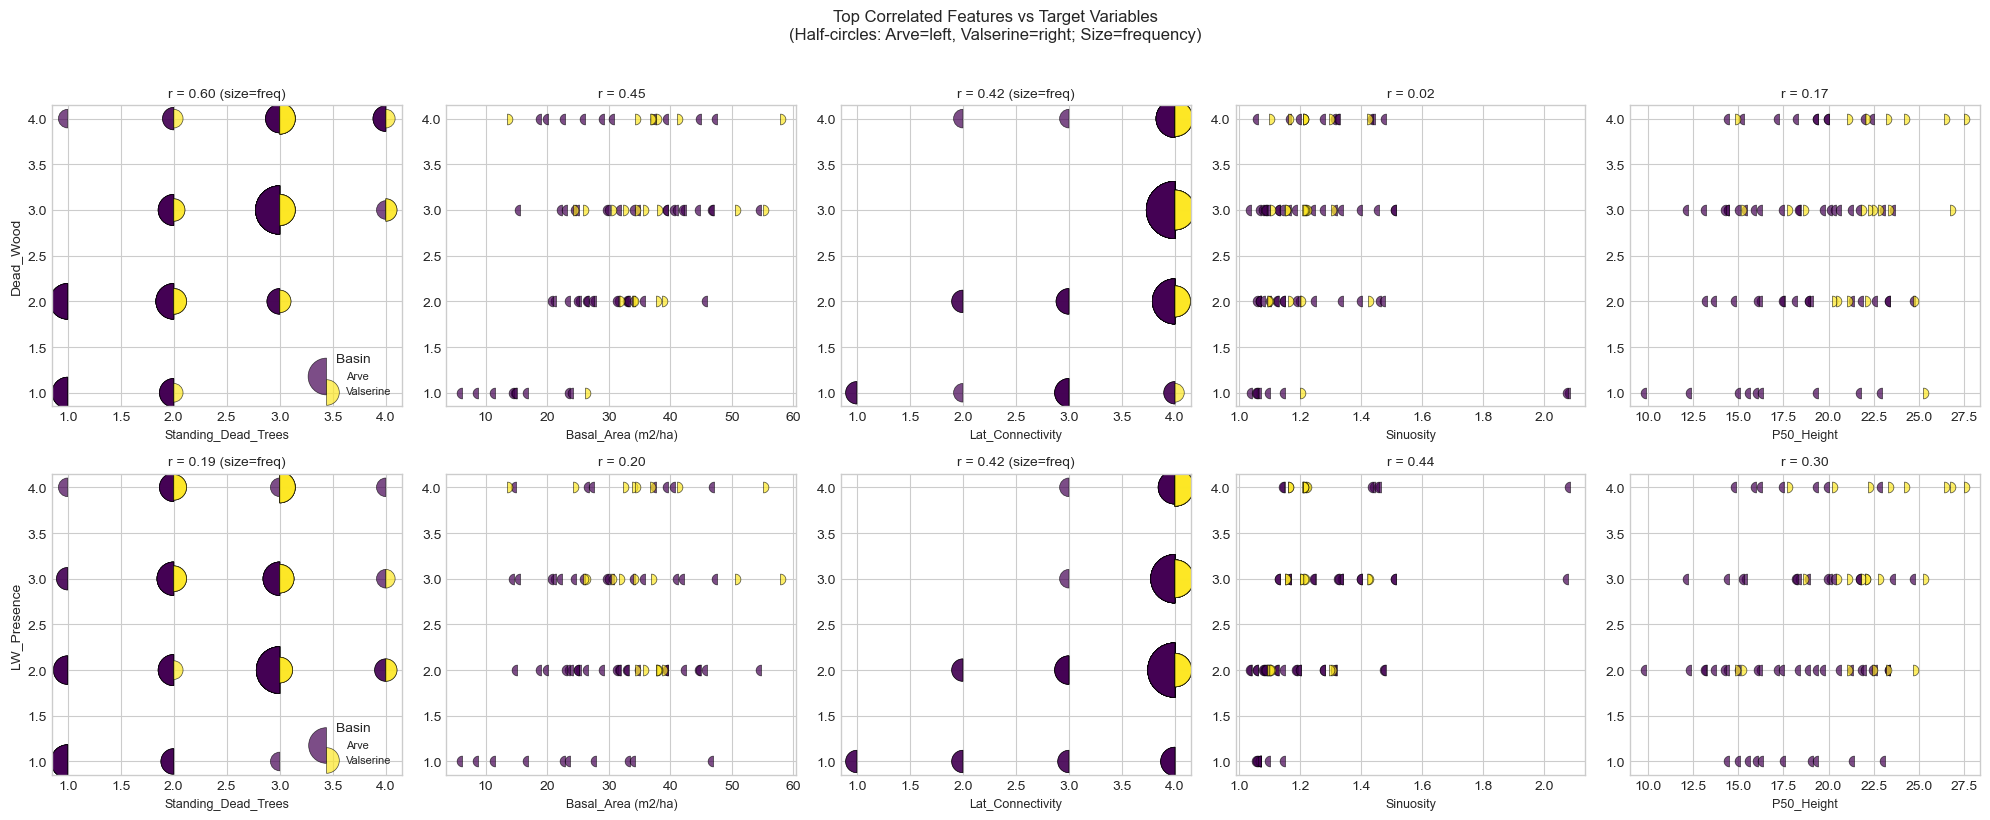

In [481]:
# Select top 6 correlated features (by absolute correlation with either target)
top_features_dw = target_corr['Dead_Wood'].abs().nlargest(3).index.tolist()
top_features_lw = target_corr['LW_Presence'].abs().nlargest(3).index.tolist()
top_features = list(dict.fromkeys(top_features_dw + top_features_lw))[:6]  # Unique, preserving order

# Define which features are discrete (for frequency-based sizing)
discrete_threshold = 10

def get_frequency_sizes_by_basin(x_data, y_data, basin_data, base_size=100, scale_factor=80):
    """Calculate point sizes based on frequency of (x, y) combinations per basin."""
    coords = pd.DataFrame({'x': x_data.values, 'y': y_data.values, 'basin': basin_data.values})
    # Calculate frequency per basin
    freq = coords.groupby(['x', 'y', 'basin']).size().reset_index(name='count')
    # Merge back
    coords_merged = coords.merge(freq, on=['x', 'y', 'basin'], how='left')
    sizes = base_size + coords_merged['count'] * scale_factor
    return sizes.values

# Create proper half-circle markers using Path with arc segments
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.patches as mpatches

def make_half_circle_left():
    """Left half circle marker (semicircle on the left side)."""
    # Use bezier curves to approximate a semicircle
    # Control point factor for circular arc approximation
    c = 0.55228  # Magic number for bezier circle approximation
    verts = [
        (0.0, 1.0),      # Top
        (-c, 1.0),       # Control point
        (-1.0, c),       # Control point
        (-1.0, 0.0),     # Left
        (-1.0, -c),      # Control point
        (-c, -1.0),      # Control point
        (0.0, -1.0),     # Bottom
        (0.0, 1.0),      # Close back to top
    ]
    codes = [
        Path.MOVETO,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CLOSEPOLY,
    ]
    return Path(verts, codes)

def make_half_circle_right():
    """Right half circle marker (semicircle on the right side)."""
    c = 0.55228
    verts = [
        (0.0, 1.0),      # Top
        (c, 1.0),        # Control point
        (1.0, c),        # Control point
        (1.0, 0.0),      # Right
        (1.0, -c),       # Control point
        (c, -1.0),       # Control point
        (0.0, -1.0),     # Bottom
        (0.0, 1.0),      # Close back to top
    ]
    codes = [
        Path.MOVETO,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CLOSEPOLY,
    ]
    return Path(verts, codes)

left_half = make_half_circle_left()
right_half = make_half_circle_right()

# Color mapping for basins
basin_colors = {basin: plt.cm.viridis(i / (len(df['Basin'].unique()) - 1)) 
                for i, basin in enumerate(df['Basin'].unique())}

# Marker mapping: Arve = left half, Valserine = right half
basin_markers = {'Arve': left_half, 'Valserine': right_half}

fig, axes = plt.subplots(2, len(top_features), figsize=(4*len(top_features), 8))

for i, feat in enumerate(top_features):
    is_discrete = df[feat].nunique() < discrete_threshold
    
    if is_discrete:
        # Calculate sizes per basin for this feature
        sizes_dict = {}
        for basin in df['Basin'].unique():
            mask = df['Basin'] == basin
            x_vals = df.loc[mask, feat]
            y_vals_dw = df.loc[mask, 'Dead_Wood']
            y_vals_lw = df.loc[mask, 'LW_Presence']
            sizes_dict[(basin, 'Dead_Wood')] = get_frequency_sizes_by_basin(
                df.loc[mask, feat], df.loc[mask, 'Dead_Wood'], df.loc[mask, 'Basin'])
            sizes_dict[(basin, 'LW_Presence')] = get_frequency_sizes_by_basin(
                df.loc[mask, feat], df.loc[mask, 'LW_Presence'], df.loc[mask, 'Basin'])
    
    # Dead_Wood scatter
    for j, basin in enumerate(df['Basin'].unique()):
        mask = df['Basin'] == basin
        x_vals = df.loc[mask, feat]
        y_vals = df.loc[mask, 'Dead_Wood']
        
        if is_discrete:
            sizes = sizes_dict[(basin, 'Dead_Wood')]
        else:
            sizes = 60
            
        axes[0, i].scatter(x_vals, y_vals, 
                          alpha=0.7, label=basin if i == 0 else '', 
                          color=basin_colors[basin], s=sizes,
                          marker=basin_markers[basin], edgecolors='black', linewidth=0.5)
    axes[0, i].set_xlabel(feat, fontsize=9)
    axes[0, i].set_ylabel('Dead_Wood' if i == 0 else '')
    r = df[[feat, 'Dead_Wood']].corr().iloc[0, 1]
    axes[0, i].set_title(f'r = {r:.2f}' + (' (size=freq)' if is_discrete else ''), fontsize=10)
    
    # LW_Presence scatter
    for j, basin in enumerate(df['Basin'].unique()):
        mask = df['Basin'] == basin
        x_vals = df.loc[mask, feat]
        y_vals = df.loc[mask, 'LW_Presence']
        
        if is_discrete:
            sizes = sizes_dict[(basin, 'LW_Presence')]
        else:
            sizes = 60
            
        axes[1, i].scatter(x_vals, y_vals, 
                          alpha=0.7, label=basin if i == 0 else '',
                          color=basin_colors[basin], s=sizes,
                          marker=basin_markers[basin], edgecolors='black', linewidth=0.5)
    axes[1, i].set_xlabel(feat, fontsize=9)
    axes[1, i].set_ylabel('LW_Presence' if i == 0 else '')
    r = df[[feat, 'LW_Presence']].corr().iloc[0, 1]
    axes[1, i].set_title(f'r = {r:.2f}' + (' (size=freq)' if is_discrete else ''), fontsize=10)

# Add legend to the first column with custom markers
axes[0, 0].legend(title='Basin', loc='best', fontsize=8)
axes[1, 0].legend(title='Basin', loc='best', fontsize=8)

plt.suptitle('Top Correlated Features vs Target Variables\n(Half-circles: Arve=left, Valserine=right; Size=frequency)', 
             fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

## 6. Feature Importance Analysis

Using Random Forest to identify which features are most predictive of our target variables.

Dead_Wood: 78 valid samples
LW_Presence: 78 valid samples


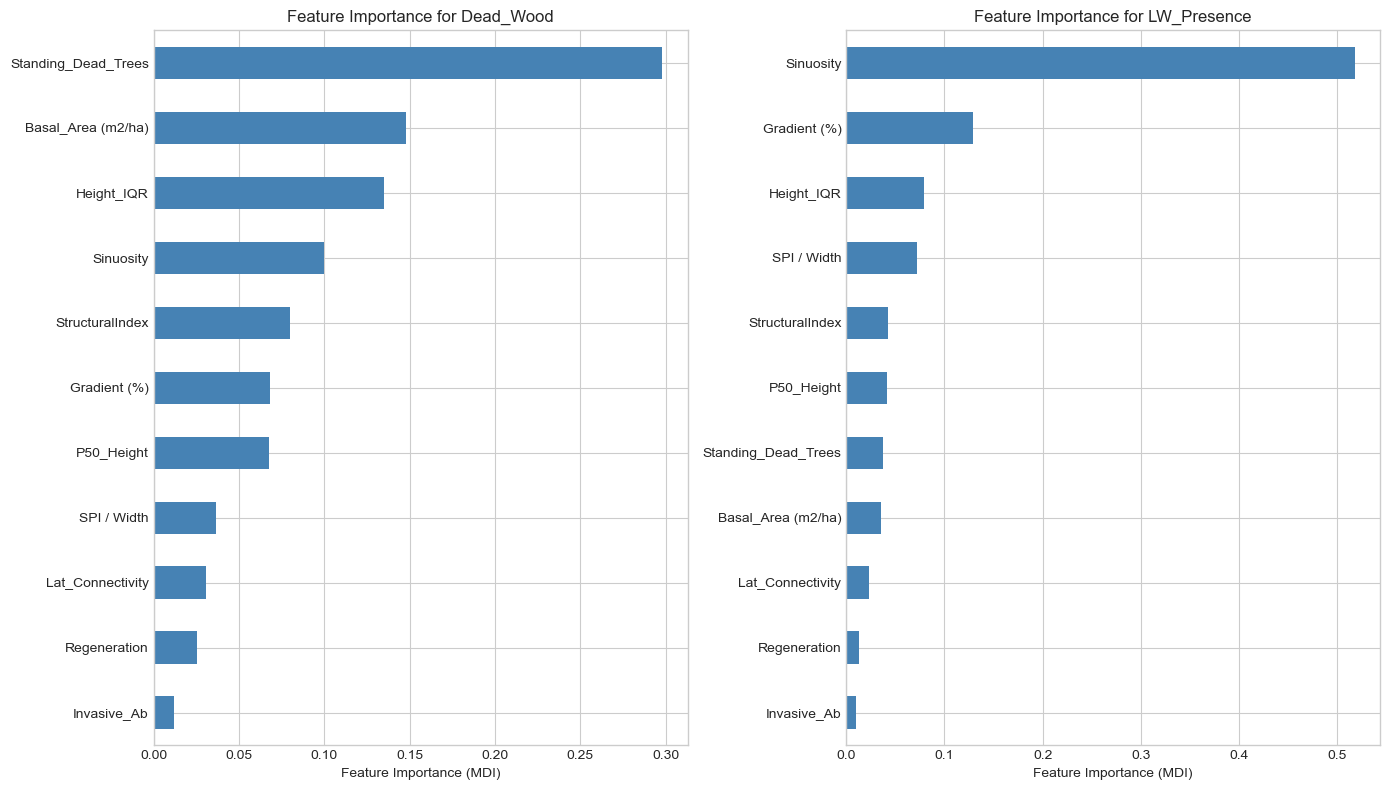

In [482]:
# Prepare feature matrix
numeric_features = df[FEATURE_COLS].select_dtypes(include=[np.number]).columns.tolist()
# Remove columns that are completely empty
numeric_features = [col for col in numeric_features if df[col].notna().any()]
feature_names = numeric_features

# Results storage
importance_results = {}

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

for idx, target in enumerate(TARGET_COLS):
    # Prepare data with proper index alignment
    data_df = df[numeric_features + [target]].dropna()
    
    if len(data_df) == 0:
        print(f"Warning: No valid samples for {target}. Skipping...")
        continue
    
    X_valid = data_df[numeric_features]
    y_valid = data_df[target]
    
    print(f"{target}: {len(X_valid)} valid samples")
    
    # Train Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_valid, y_valid)
    
    # Get feature importances
    importances = pd.Series(rf.feature_importances_, index=feature_names)
    importances = importances.sort_values(ascending=True)
    importance_results[target] = importances
    
    # Plot
    importances.plot(kind='barh', ax=axes[idx], color='steelblue')
    axes[idx].set_xlabel('Feature Importance (MDI)')
    axes[idx].set_title(f'Feature Importance for {target}')

plt.tight_layout()
plt.show()


In [483]:
# Compare top important features for both targets
print("Top 5 Important Features Comparison:")
print("="*60)
print(f"{'Rank':<6}{'Dead_Wood':<25}{'LW_Presence':<25}")
print("-"*60)

dw_top = importance_results['Dead_Wood'].nlargest(5)
lw_top = importance_results['LW_Presence'].nlargest(5)

for i in range(5):
    dw_feat = f"{dw_top.index[i]} ({dw_top.iloc[i]:.3f})"
    lw_feat = f"{lw_top.index[i]} ({lw_top.iloc[i]:.3f})"
    print(f"{i+1:<6}{dw_feat:<25}{lw_feat:<25}")

Top 5 Important Features Comparison:
Rank  Dead_Wood                LW_Presence              
------------------------------------------------------------
1     Standing_Dead_Trees (0.298)Sinuosity (0.518)        
2     Basal_Area (m2/ha) (0.148)Gradient (%) (0.129)     
3     Height_IQR (0.135)       Height_IQR (0.079)       
4     Sinuosity (0.100)        SPI / Width (0.072)      
5     StructuralIndex (0.080)  StructuralIndex (0.042)  


5-Fold Cross-Validation (GroupKFold by Reach)

Dead_Wood (n=78 samples)
Fold  R² Train    R² Test     MAE       RMSE      
--------------------------------------------------
1     0.9130      -0.2863     0.8556    1.0981    
2     0.8982      -0.1321     0.6038    0.7254    
3     0.8951      0.5571      0.5931    0.6745    
4     0.8983      0.1920      0.6975    0.8971    
5     0.8867      0.4522      0.4279    0.5391    

Metric              Train          Test           
--------------------------------------------------
R² Mean             0.8983         0.1566         
R² Std              0.0085         0.3251         
MAE Mean            ---            0.6356         
MAE Std             ---            0.1402         
RMSE Mean           ---            0.7869         
RMSE Std            ---            0.1933         

LW_Presence (n=78 samples)
Fold  R² Train    R² Test     MAE       RMSE      
--------------------------------------------------
1     0.9393      0.3623      0.

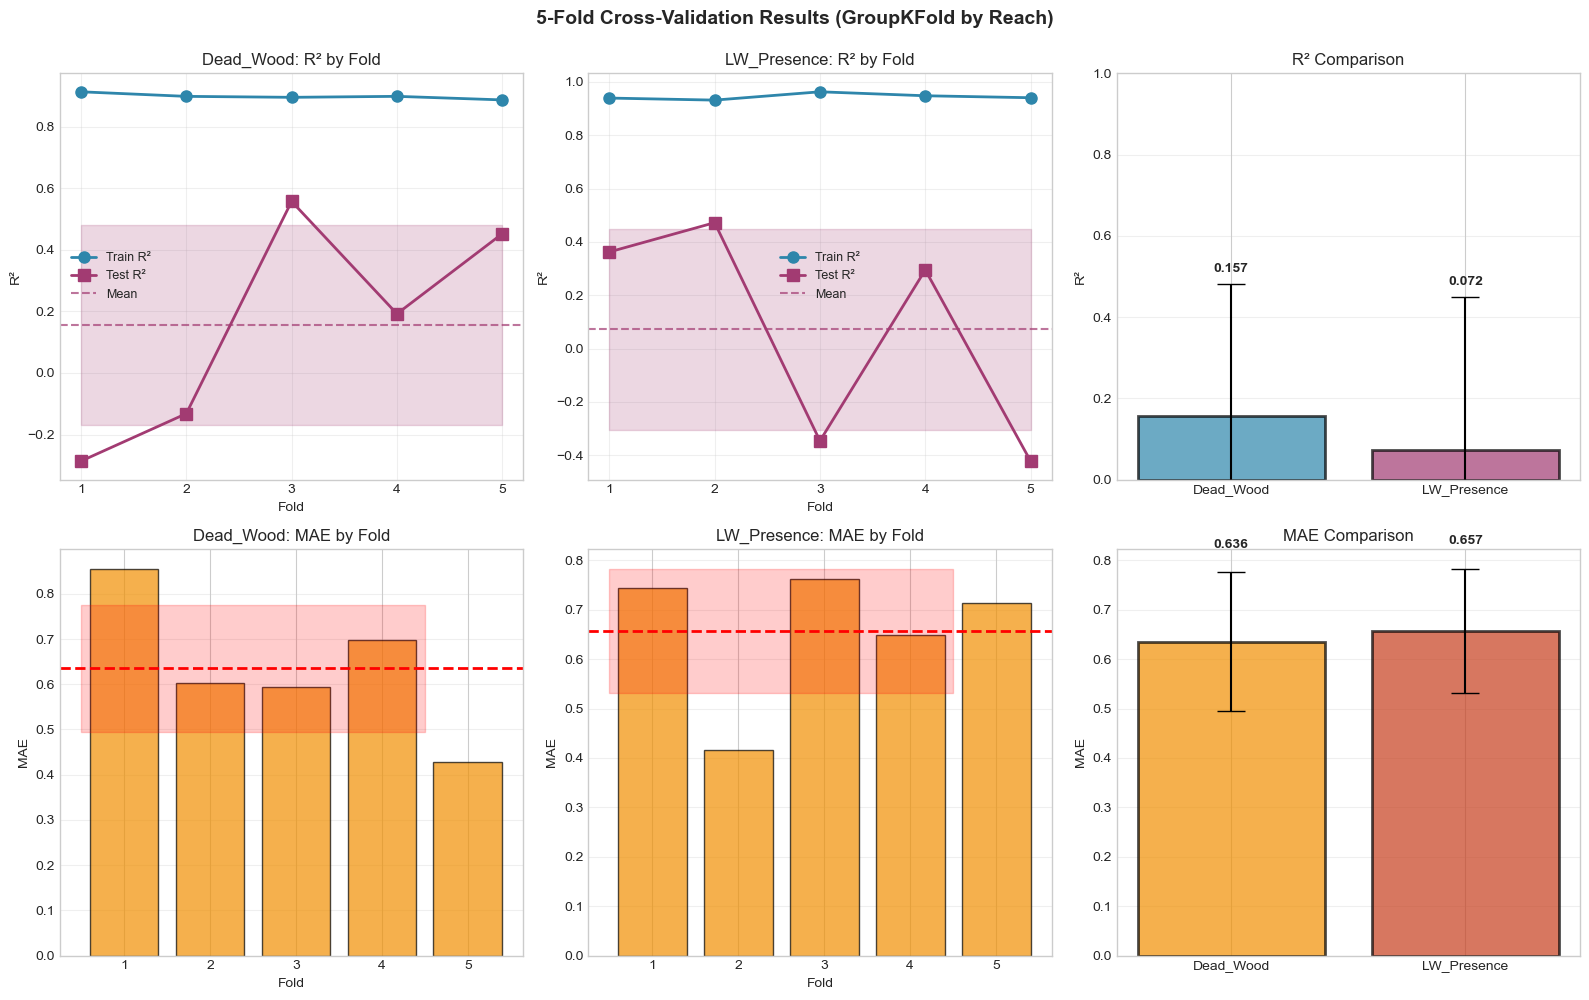

In [484]:
from sklearn.model_selection import cross_validate, GroupKFold

# Group by Reach to avoid data leakage
data_df_cv = df[numeric_features + TARGET_COLS + ['Reach']].dropna()
groups = pd.factorize(data_df_cv['Reach'])[0]
gkfold = GroupKFold(n_splits=5)

# Define scoring metrics
scoring = {
    'r2': 'r2',
    'neg_mae': 'neg_mean_absolute_error',
    'neg_mse': 'neg_mean_squared_error'
}

cv_results_all = {}

print("="*80)
print("5-Fold Cross-Validation (GroupKFold by Reach)")
print("="*80)

for target in TARGET_COLS:
    print(f"\n{target} (n={len(data_df_cv)} samples)")
    
    X = data_df_cv[numeric_features]
    y = data_df_cv[target]
    
    # Cross-validation
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    cv_results = cross_validate(rf, X, y, cv=gkfold, groups=groups, 
                                scoring=scoring, return_train_score=True)
    
    # Convert metrics to positive values
    cv_results['mae'] = -cv_results['test_neg_mae']
    cv_results['rmse'] = np.sqrt(-cv_results['test_neg_mse'])
    cv_results['train_mae'] = -cv_results['train_neg_mae']
    cv_results['train_rmse'] = np.sqrt(-cv_results['train_neg_mse'])
    
    cv_results_all[target] = cv_results
    
    # Print results by fold
    print(f"{'Fold':<6}{'R² Train':<12}{'R² Test':<12}{'MAE':<10}{'RMSE':<10}")
    print("-" * 50)
    for i in range(5):
        print(f"{i+1:<6}{cv_results['train_r2'][i]:<12.4f}{cv_results['test_r2'][i]:<12.4f}{cv_results['mae'][i]:<10.4f}{cv_results['rmse'][i]:<10.4f}")
    
    # Summary statistics
    print(f"\n{'Metric':<20}{'Train':<15}{'Test':<15}")
    print("-" * 50)
    print(f"{'R² Mean':<20}{cv_results['train_r2'].mean():<15.4f}{cv_results['test_r2'].mean():<15.4f}")
    print(f"{'R² Std':<20}{cv_results['train_r2'].std():<15.4f}{cv_results['test_r2'].std():<15.4f}")
    print(f"{'MAE Mean':<20}{'---':<15}{cv_results['mae'].mean():<15.4f}")
    print(f"{'MAE Std':<20}{'---':<15}{cv_results['mae'].std():<15.4f}")
    print(f"{'RMSE Mean':<20}{'---':<15}{cv_results['rmse'].mean():<15.4f}")
    print(f"{'RMSE Std':<20}{'---':<15}{cv_results['rmse'].std():<15.4f}")

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

for idx, target in enumerate(TARGET_COLS):
    cv_results = cv_results_all[target]
    folds = np.arange(1, 6)
    
    # R² by fold
    ax = axes[0, idx]
    ax.plot(folds, cv_results['train_r2'], 'o-', linewidth=2, markersize=8, 
            label='Train R²', color='#2E86AB')
    ax.plot(folds, cv_results['test_r2'], 's-', linewidth=2, markersize=8, 
            label='Test R²', color='#A23B72')
    ax.axhline(cv_results['test_r2'].mean(), color='#A23B72', linestyle='--', 
               alpha=0.7, label='Mean')
    ax.fill_between(folds, 
                    cv_results['test_r2'].mean() - cv_results['test_r2'].std(),
                    cv_results['test_r2'].mean() + cv_results['test_r2'].std(),
                    alpha=0.2, color='#A23B72')
    ax.set_xlabel('Fold')
    ax.set_ylabel('R²')
    ax.set_title(f'{target}: R² by Fold')
    ax.set_xticks(folds)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    
    # MAE by fold
    ax = axes[1, idx]
    ax.bar(folds, cv_results['mae'], alpha=0.7, color='#F18F01', edgecolor='black')
    ax.axhline(cv_results['mae'].mean(), color='red', linestyle='--', linewidth=2)
    ax.fill_between(folds - 0.5, 
                    cv_results['mae'].mean() - cv_results['mae'].std(),
                    cv_results['mae'].mean() + cv_results['mae'].std(),
                    alpha=0.2, color='red')
    ax.set_xlabel('Fold')
    ax.set_ylabel('MAE')
    ax.set_title(f'{target}: MAE by Fold')
    ax.set_xticks(folds)
    ax.grid(True, alpha=0.3, axis='y')

# Summary comparison
ax = axes[0, 2]
x_pos = np.arange(len(TARGET_COLS))
r2_means = [cv_results_all[t]['test_r2'].mean() for t in TARGET_COLS]
r2_stds = [cv_results_all[t]['test_r2'].std() for t in TARGET_COLS]

bars = ax.bar(x_pos, r2_means, yerr=r2_stds, capsize=10, alpha=0.7, 
              color=['#2E86AB', '#A23B72'], edgecolor='black', linewidth=2)
ax.set_ylabel('R²')
ax.set_title('R² Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(TARGET_COLS)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1)

for bar, mean, std in zip(bars, r2_means, r2_stds):
    ax.text(bar.get_x() + bar.get_width()/2, mean + std + 0.03, f'{mean:.3f}', 
            ha='center', fontsize=10, fontweight='bold')

# MAE comparison
ax = axes[1, 2]
mae_means = [cv_results_all[t]['mae'].mean() for t in TARGET_COLS]
mae_stds = [cv_results_all[t]['mae'].std() for t in TARGET_COLS]

bars = ax.bar(x_pos, mae_means, yerr=mae_stds, capsize=10, alpha=0.7, 
              color=['#F18F01', '#C73E1D'], edgecolor='black', linewidth=2)
ax.set_ylabel('MAE')
ax.set_title('MAE Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(TARGET_COLS)
ax.grid(True, alpha=0.3, axis='y')

for bar, mean, std in zip(bars, mae_means, mae_stds):
    ax.text(bar.get_x() + bar.get_width()/2, mean + std + 0.05, f'{mean:.3f}', 
            ha='center', fontsize=10, fontweight='bold')

plt.suptitle('5-Fold Cross-Validation Results (GroupKFold by Reach)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 7. Relationship Between Target Variables

This section explores **how our two main variables of interest relate to each other**. Understanding this relationship is important because:
- If they are highly correlated, they may be driven by similar underlying ecological processes
- If they differ by basin, it suggests location-specific factors influence their relationship

**How to read these plots:**
- **Left plot:** Overall scatter of Dead_Wood vs LW_Presence, colored by Basin
- **Right plot:** Same relationship but with **linear regression trend lines** for each Basin
- **r value:** Overall Pearson correlation between the two target variables

The dashed trend lines show whether the relationship direction/strength differs between the Arve and Valserine basins.

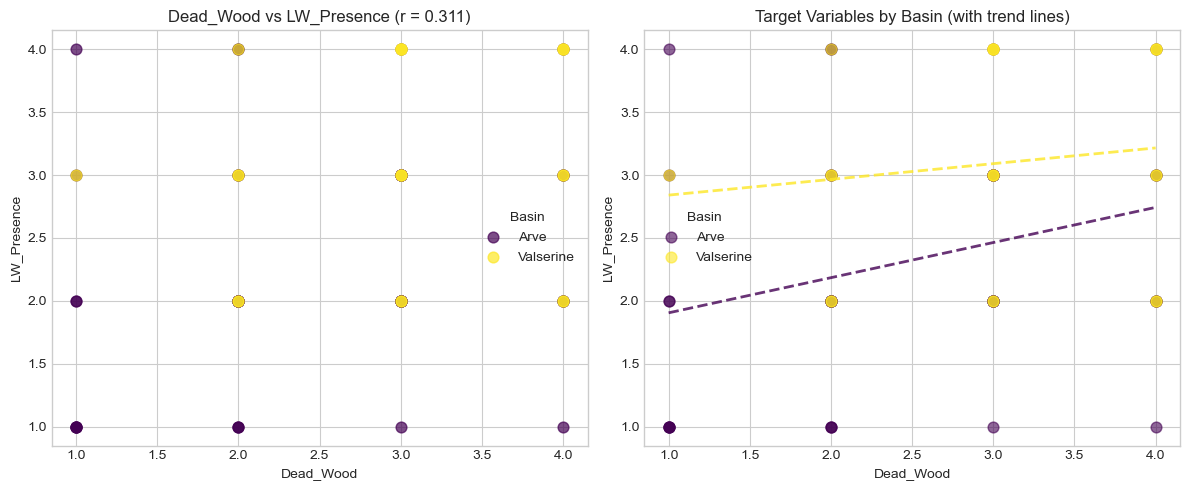


Correlation between Dead_Wood and LW_Presence by Basin:
  Arve: r = 0.295
  Valserine: r = 0.135


In [485]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Color palette for basins
basin_colors = {basin: plt.cm.viridis(i / (len(df['Basin'].unique()) - 1)) 
                for i, basin in enumerate(df['Basin'].unique())}

# Left plot: Scatter plot of target variables with proper legend
for basin in df['Basin'].unique():
    subset = df[df['Basin'] == basin]
    axes[0].scatter(subset['Dead_Wood'], subset['LW_Presence'], 
                   c=[basin_colors[basin]], alpha=0.7, s=60, label=basin)

axes[0].set_xlabel('Dead_Wood')
axes[0].set_ylabel('LW_Presence')
r = df[['Dead_Wood', 'LW_Presence']].corr().iloc[0, 1]
axes[0].set_title(f'Dead_Wood vs LW_Presence (r = {r:.3f})')
axes[0].legend(title='Basin', loc='best')

# Right plot: Distribution by Basin with regression lines
for basin in df['Basin'].unique():
    subset = df[df['Basin'] == basin]
    axes[1].scatter(subset['Dead_Wood'], subset['LW_Presence'], 
                   alpha=0.6, s=60, label=basin, c=[basin_colors[basin]])
    # Add regression line per basin
    z = np.polyfit(subset['Dead_Wood'].dropna(), 
                   subset.loc[subset['Dead_Wood'].notna(), 'LW_Presence'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(subset['Dead_Wood'].min(), subset['Dead_Wood'].max(), 100)
    axes[1].plot(x_line, p(x_line), '--', alpha=0.8, color=basin_colors[basin], linewidth=2)

axes[1].set_xlabel('Dead_Wood')
axes[1].set_ylabel('LW_Presence')
axes[1].set_title('Target Variables by Basin (with trend lines)')
axes[1].legend(title='Basin', loc='best')

plt.tight_layout()
plt.show()

# Print correlation by basin
print("\nCorrelation between Dead_Wood and LW_Presence by Basin:")
for basin in df['Basin'].unique():
    subset = df[df['Basin'] == basin]
    r_basin = subset[['Dead_Wood', 'LW_Presence']].corr().iloc[0, 1]
    print(f"  {basin}: r = {r_basin:.3f}")

## 8. Summary Statistics by Location

Examining how target variables vary across different Sub-Basins.

In [486]:
# Summary by Sub_Basin
location_summary = df.groupby(['Basin', 'Sub_Basin'])[TARGET_COLS + FEATURE_COLS[:5]].agg(['mean', 'std', 'count'])
location_summary = location_summary.round(2)

# Display target variable summary
target_summary = df.groupby(['Basin', 'Sub_Basin'])[TARGET_COLS].agg(['mean', 'std', 'min', 'max', 'count'])
print("Target Variables by Location:")
print("="*80)
print(target_summary)

Target Variables by Location:
                    Dead_Wood                         LW_Presence            \
                         mean       std min max count        mean       std   
Basin     Sub_Basin                                                           
Arve      Arve       2.382353  1.015477   1   4    34    2.323529  1.006662   
          Giffre     2.750000  0.856349   1   4    16    2.000000  0.516398   
          Menoge     3.000000  0.894427   2   4     6    3.333333  0.516398   
Valserine Semine     2.625000  1.187735   1   4     8    3.000000  0.755929   
          Valserine  3.214286  0.578934   2   4    14    3.142857  0.864438   

                                   
                    min max count  
Basin     Sub_Basin                
Arve      Arve        1   4    34  
          Giffre      1   3    16  
          Menoge      3   4     6  
Valserine Semine      2   4     8  
          Valserine   2   4    14  


C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_28300\2405215004.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_28300\2405215004.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


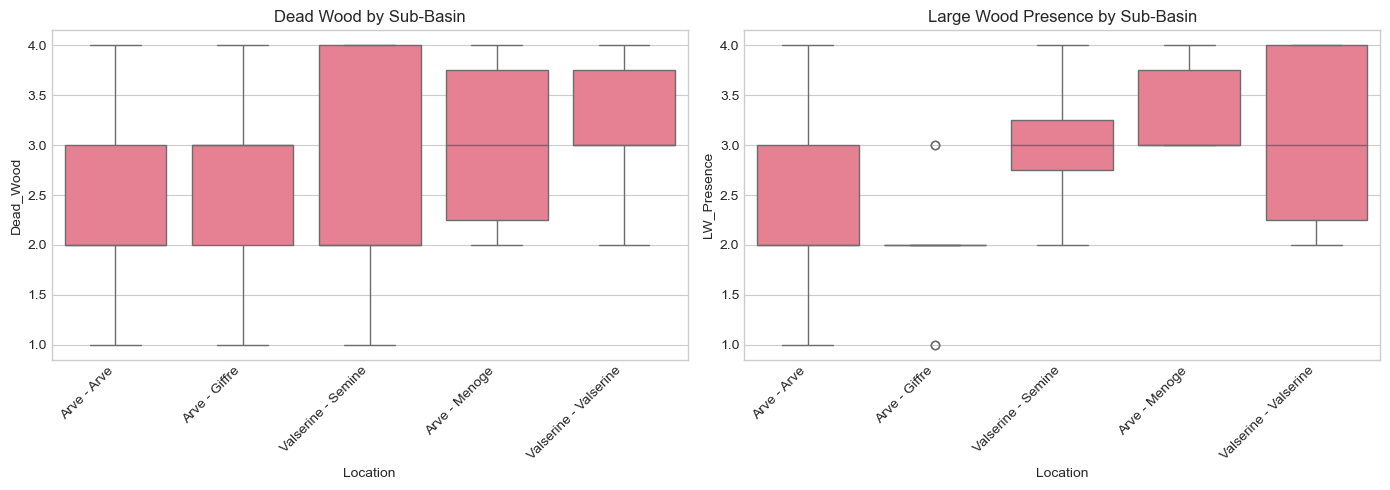

In [487]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df_plot = df.copy()
df_plot['Location'] = df_plot['Basin'] + ' - ' + df_plot['Sub_Basin']

sns.boxplot(data=df_plot, x='Location', y='Dead_Wood', ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title('Dead Wood by Sub-Basin')

sns.boxplot(data=df_plot, x='Location', y='LW_Presence', ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title('Large Wood Presence by Sub-Basin')

plt.tight_layout()
plt.show()

## 9. Feature Value Ranges Associated with Target Values 1-4

This section identifies which **values and ranges** of the top 8 most important features 
are associated with different target values (1-4).

This is useful for understanding:
- What feature ranges characterize each target category
- Whether there are clear value thresholds that distinguish target classes
- How feature distributions shift across target values

**Visualizations:**
- **Violin plots:** Show full distribution of each feature for each target value
- **Heatmap:** Displays median feature values across target categories
- **Distribution plots:** Highlight how features concentrate at different target levels

In [488]:
# Get top 8 most important features for EACH target variable separately
top_n = 8

# Get importance scores
dw_importance = importance_results['Dead_Wood'].sort_values(ascending=False)
lw_importance = importance_results['LW_Presence'].sort_values(ascending=False)

# Create separate top 8 lists for each target
top_8_features_dw = dw_importance.head(top_n).index.tolist()
top_8_features_lw = lw_importance.head(top_n).index.tolist()

print(f"Top {top_n} Most Important Features for Dead_Wood:")
print("="*50)
for i, feat in enumerate(top_8_features_dw, 1):
    print(f"{i}. {feat}: {dw_importance[feat]:.4f}")

print(f"\n\nTop {top_n} Most Important Features for LW_Presence:")
print("="*50)
for i, feat in enumerate(top_8_features_lw, 1):
    print(f"{i}. {feat}: {lw_importance[feat]:.4f}")

Top 8 Most Important Features for Dead_Wood:
1. Standing_Dead_Trees: 0.2979
2. Basal_Area (m2/ha): 0.1476
3. Height_IQR: 0.1348
4. Sinuosity: 0.0998
5. StructuralIndex: 0.0799
6. Gradient (%): 0.0681
7. P50_Height: 0.0676
8. SPI / Width: 0.0364


Top 8 Most Important Features for LW_Presence:
1. Sinuosity: 0.5176
2. Gradient (%): 0.1289
3. Height_IQR: 0.0791
4. SPI / Width: 0.0718
5. StructuralIndex: 0.0423
6. P50_Height: 0.0418
7. Standing_Dead_Trees: 0.0377
8. Basal_Area (m2/ha): 0.0349


In [489]:
# Prepare data for Dead_Wood analysis
df_dead_wood = df[df['Dead_Wood'].isin([1, 2, 3, 4])].copy()
df_dead_wood['Dead_Wood_Category'] = df_dead_wood['Dead_Wood'].astype(str)

print(f"Dead_Wood data prepared:")
print(f"  Total samples: {len(df_dead_wood)}")
print(f"  Dead_Wood categories: {sorted(df_dead_wood['Dead_Wood'].unique())}")

# Prepare data for LW_Presence analysis
df_lw = df[df['LW_Presence'].isin([1, 2, 3, 4])].copy()
df_lw['LW_Presence_Category'] = df_lw['LW_Presence'].astype(str)

print(f"\nLW_Presence data prepared:")
print(f"  Total samples: {len(df_lw)}")
print(f"  LW_Presence categories: {sorted(df_lw['LW_Presence'].unique())}")

Dead_Wood data prepared:
  Total samples: 78
  Dead_Wood categories: [1, 2, 3, 4]

LW_Presence data prepared:
  Total samples: 78
  LW_Presence categories: [1, 2, 3, 4]


### Dead_Wood Analysis: Distribution of Top Features by Dead_Wood Value (1-4)

In [490]:
# Summary statistics for Dead_Wood analysis
print("\n" + "="*80)
print("SUMMARY: Feature Statistics by Dead_Wood Value")
print("="*80)

for feat in top_8_features_dw:
    print(f"\n{feat}:")
    print("-" * 60)
    summary = df_dead_wood.groupby('Dead_Wood_Category')[feat].agg(['count', 'mean', 'std', 'min', 'max'])
    print(summary.round(2))


SUMMARY: Feature Statistics by Dead_Wood Value

Standing_Dead_Trees:
------------------------------------------------------------
                    count  mean   std  min  max
Dead_Wood_Category                             
1                      10  1.50  0.53    1    2
2                      22  1.91  0.75    1    3
3                      29  2.86  0.58    2    4
4                      17  2.94  0.83    1    4

Basal_Area (m2/ha):
------------------------------------------------------------
                    count   mean    std    min    max
Dead_Wood_Category                                   
1                      10  16.18   6.70   6.20  26.15
2                      22  30.96   6.04  20.95  45.95
3                      29  35.81  10.00  15.60  55.15
4                      17  33.91  11.36  13.40  57.91

Height_IQR:
------------------------------------------------------------
                    count  mean   std  min   max
Dead_Wood_Category                              
1  

c:\Users\jdelhoyo\anaconda3\envs\woodrf\lib\site-packages\ptitprince\PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
c:\Users\jdelhoyo\anaconda3\envs\woodrf\lib\site-packages\ptitprince\PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
c:\Users\jdelhoyo\anaconda3\envs\woodrf\lib\site-packages\ptitprince\PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
c:\Users\jdelhoyo\anaconda3\envs\woodrf\lib\site-packages\ptitprince\PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigni

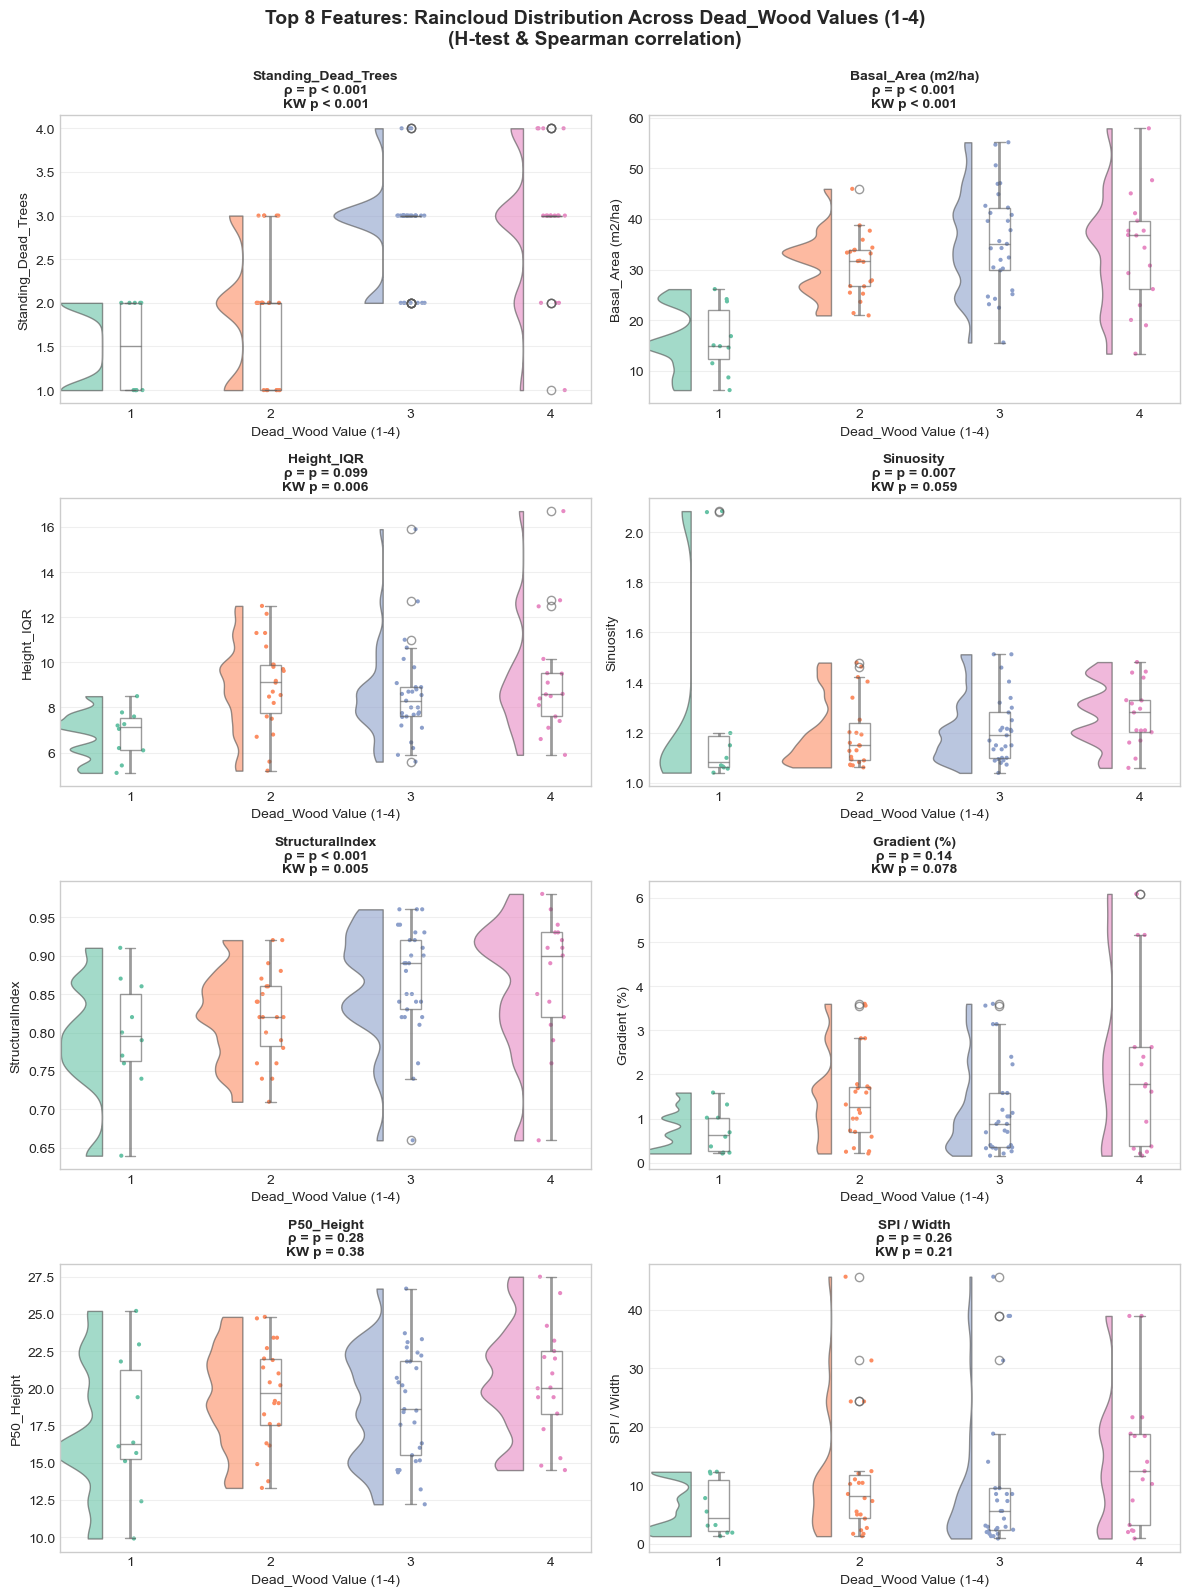

In [ ]:
# Install ptitprince for raincloud plots if needed
try:
    import ptitprince as pt
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ptitprince", "-q"])
    import ptitprince as pt

# Raincloud plots for Dead_Wood - Shows distribution + individual points WITH statistical tests
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
axes = axes.flatten()

for i, feat in enumerate(top_8_features_dw):
    # Remove NaN values for this feature
    plot_data = df_dead_wood[[feat, 'Dead_Wood_Category']].dropna()
    
    if len(plot_data) > 0:
        pt.RainCloud(data=plot_data, x='Dead_Wood_Category', y=feat, ax=axes[i], 
                     palette='Set2', order=['1', '2', '3', '4'], alpha=0.6)
        axes[i].set_xlabel('Dead_Wood Value (1-4)', fontsize=10)
        axes[i].set_ylabel(feat, fontsize=10)
        
        # Get statistical test results for this feature
        feat_stats = stats_dw_df[stats_dw_df['Feature'] == feat].iloc[0]
        kw_p = feat_stats['KW p-value']
        rho = feat_stats['Spearman rho']
        spear_p = feat_stats['Spearman p-value']
        
        # Set title with statistical results
        title_text = f'{feat}\nρ = {rho:.2f}, {format_pvalue(spear_p)}\nKW {format_pvalue(kw_p)}'
        axes[i].set_title(title_text, fontsize=10, fontweight='bold')
        axes[i].grid(axis='y', alpha=0.3)

plt.suptitle('Top 8 Features: Raincloud Distribution Across Dead_Wood Values (1-4)\n(H-test & Spearman correlation)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [492]:
# Helper function to format p-values for publication-quality output
def format_pvalue(p):
    """
    Format p-value based on magnitude:
    - p < 0.001 → "p < 0.001"
    - 0.001 ≤ p < 0.01 → 3 decimals (e.g., "p = 0.005")
    - 0.01 ≤ p < 0.1 → 3 decimals (e.g., "p = 0.058")
    - p ≥ 0.1 → 2 decimals (e.g., "p = 0.12")
    """
    if p < 0.001:
        return "p < 0.001"
    elif p < 0.01:
        return f"p = {p:.3f}"
    elif p < 0.1:
        return f"p = {p:.3f}"
    else:
        return f"p = {p:.2f}"


In [493]:
# Statistical tests for Dead_Wood: Kruskal-Wallis and Spearman correlation
from scipy.stats import kruskal, spearmanr

print('\n' + '='*100)
print('STATISTICAL TESTS FOR DEAD_WOOD - Top 8 Features')
print('='*100)
print(f'\nKruskal-Wallis (H-test) - Tests if distributions differ across Dead_Wood Classes (1-4)')
print(f'Spearman rho - Correlation with Dead_Wood ordinal variable (1-4)')
print('\n' + '-'*100)
print(f'{"Feature":<30} {"Kruskal-Wallis H":<20} {"p-value (KW)":<18} {"Spearman rho":<18} {"p-value (Spearman)":<18}')
print('-'*100)

stats_dw = []

for feat in top_8_features_dw:
    # Prepare data
    feat_data = df_dead_wood[[feat, 'Dead_Wood_Category']].dropna()
    
    if len(feat_data) > 0:
        # Kruskal-Wallis test
        groups = [feat_data[feat_data['Dead_Wood_Category'] == str(i)][feat].values 
                  for i in [1, 2, 3, 4]]
        groups = [g for g in groups if len(g) > 0]  # Remove empty groups
        
        if len(groups) > 1:
            h_stat, kw_pvalue = kruskal(*groups)
        else:
            h_stat, kw_pvalue = np.nan, np.nan
        
        # Spearman correlation with ordinal Dead_Wood
        dead_wood_numeric = feat_data['Dead_Wood_Category'].astype(int)
        rho, spear_pvalue = spearmanr(feat_data[feat], dead_wood_numeric)
        
        stats_dw.append({
            'Feature': feat,
            'Kruskal-Wallis H': h_stat,
            'KW p-value': kw_pvalue,
            'Spearman rho': rho,
            'Spearman p-value': spear_pvalue
        })
        
        print(f'{feat:<30} {h_stat:<20.4f} {kw_pvalue:<18.4e} {rho:<18.4f} {spear_pvalue:<18.4e}')

# Create DataFrame for better visualization
stats_dw_df = pd.DataFrame(stats_dw)
print('\n' + '='*100)
print('Summary Table:')
print(stats_dw_df.to_string(index=False))


STATISTICAL TESTS FOR DEAD_WOOD - Top 8 Features

Kruskal-Wallis (H-test) - Tests if distributions differ across Dead_Wood Classes (1-4)
Spearman rho - Correlation with Dead_Wood ordinal variable (1-4)

----------------------------------------------------------------------------------------------------
Feature                        Kruskal-Wallis H     p-value (KW)       Spearman rho       p-value (Spearman)
----------------------------------------------------------------------------------------------------
Standing_Dead_Trees            32.4782              4.1495e-07         0.6073             3.7506e-09        
Basal_Area (m2/ha)             22.5826              4.9338e-05         0.4053             2.3256e-04        
Height_IQR                     12.3090              6.3963e-03         0.1881             9.9122e-02        
Sinuosity                      7.4609               5.8572e-02         0.3044             6.7374e-03        
StructuralIndex                12.8257           

### Large Wood Presence Analysis: Distribution of Top Features by LW_Presence Value (1-4)

In [494]:
# Summary statistics for LW_Presence analysis
print("\n" + "="*80)
print("SUMMARY: Feature Statistics by LW_Presence Value")
print("="*80)

for feat in top_8_features_lw:
    print(f"\n{feat}:")
    print("-" * 60)
    summary = df_lw.groupby('LW_Presence_Category')[feat].agg(['count', 'mean', 'std', 'min', 'max'])
    print(summary.round(2))


SUMMARY: Feature Statistics by LW_Presence Value

Sinuosity:
------------------------------------------------------------
                      count  mean   std   min   max
LW_Presence_Category                               
1                        10  1.08  0.03  1.06  1.15
2                        30  1.17  0.12  1.04  1.48
3                        23  1.32  0.20  1.13  2.08
4                        15  1.32  0.24  1.15  2.08

Gradient (%):
------------------------------------------------------------
                      count  mean   std   min   max
LW_Presence_Category                               
1                        10  1.41  1.19  0.37  3.56
2                        30  1.14  0.87  0.21  2.82
3                        23  1.25  1.60  0.16  6.09
4                        15  2.37  1.63  0.23  5.16

Height_IQR:
------------------------------------------------------------
                      count  mean   std  min    max
LW_Presence_Category                               

c:\Users\jdelhoyo\anaconda3\envs\woodrf\lib\site-packages\ptitprince\PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
c:\Users\jdelhoyo\anaconda3\envs\woodrf\lib\site-packages\ptitprince\PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
c:\Users\jdelhoyo\anaconda3\envs\woodrf\lib\site-packages\ptitprince\PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
c:\Users\jdelhoyo\anaconda3\envs\woodrf\lib\site-packages\ptitprince\PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigni

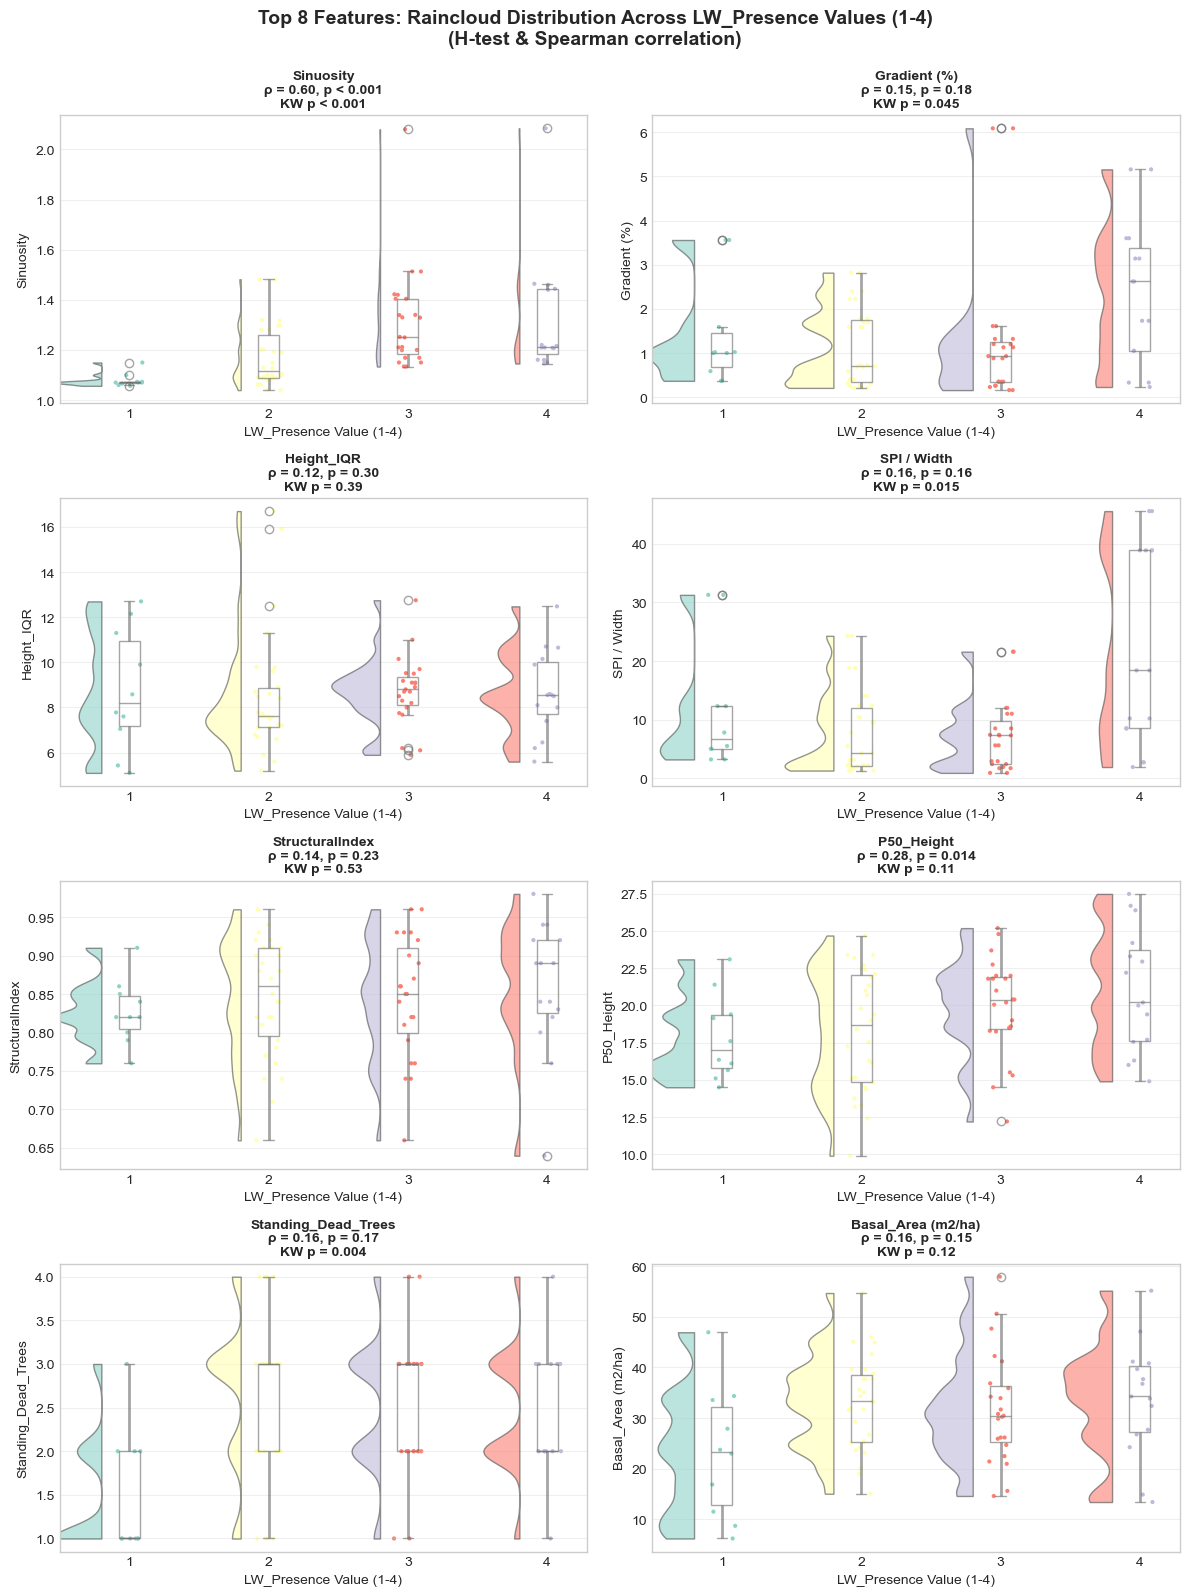

In [495]:
# Raincloud plots for LW_Presence - Shows distribution + individual points WITH statistical tests
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
axes = axes.flatten()

for i, feat in enumerate(top_8_features_lw):
    # Remove NaN values for this feature
    plot_data = df_lw[[feat, 'LW_Presence_Category']].dropna()
    
    if len(plot_data) > 0:
        pt.RainCloud(data=plot_data, x='LW_Presence_Category', y=feat, ax=axes[i], 
                     palette='Set3', order=['1', '2', '3', '4'], alpha=0.6)
        axes[i].set_xlabel('LW_Presence Value (1-4)', fontsize=10)
        axes[i].set_ylabel(feat, fontsize=10)
        
        # Get statistical test results for this feature
        feat_stats = stats_lw_df[stats_lw_df['Feature'] == feat].iloc[0]
        kw_p = feat_stats['KW p-value']
        rho = feat_stats['Spearman rho']
        spear_p = feat_stats['Spearman p-value']
        
        # Set title with statistical results
        title_text = f'{feat}\nρ = {rho:.2f}, {format_pvalue(spear_p)}\nKW {format_pvalue(kw_p)}'
        axes[i].set_title(title_text, fontsize=10, fontweight='bold')
        axes[i].grid(axis='y', alpha=0.3)

plt.suptitle('Top 8 Features: Raincloud Distribution Across LW_Presence Values (1-4)\n(H-test & Spearman correlation)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [496]:
# Statistical tests for LW_Presence: Kruskal-Wallis and Spearman correlation
print('\n' + '='*100)
print('STATISTICAL TESTS FOR LW_PRESENCE - Top 8 Features')
print('='*100)
print(f'\nKruskal-Wallis (H-test) - Tests if distributions differ across LW_Presence Classes (1-4)')
print(f'Spearman rho - Correlation with LW_Presence ordinal variable (1-4)')
print('\n' + '-'*100)
print(f'{"Feature":<30} {"Kruskal-Wallis H":<20} {"p-value (KW)":<18} {"Spearman rho":<18} {"p-value (Spearman)":<18}')
print('-'*100)

stats_lw = []

for feat in top_8_features_lw:
    # Prepare data
    feat_data = df_lw[[feat, 'LW_Presence_Category']].dropna()
    
    if len(feat_data) > 0:
        # Kruskal-Wallis test
        groups = [feat_data[feat_data['LW_Presence_Category'] == str(i)][feat].values 
                  for i in [1, 2, 3, 4]]
        groups = [g for g in groups if len(g) > 0]  # Remove empty groups
        
        if len(groups) > 1:
            h_stat, kw_pvalue = kruskal(*groups)
        else:
            h_stat, kw_pvalue = np.nan, np.nan
        
        # Spearman correlation with ordinal LW_Presence
        lw_numeric = feat_data['LW_Presence_Category'].astype(int)
        rho, spear_pvalue = spearmanr(feat_data[feat], lw_numeric)
        
        stats_lw.append({
            'Feature': feat,
            'Kruskal-Wallis H': h_stat,
            'KW p-value': kw_pvalue,
            'Spearman rho': rho,
            'Spearman p-value': spear_pvalue
        })
        
        print(f'{feat:<30} {h_stat:<20.4f} {kw_pvalue:<18.4e} {rho:<18.4f} {spear_pvalue:<18.4e}')

# Create DataFrame for better visualization
stats_lw_df = pd.DataFrame(stats_lw)
print('\n' + '='*100)
print('Summary Table:')
print(stats_lw_df.to_string(index=False))


STATISTICAL TESTS FOR LW_PRESENCE - Top 8 Features

Kruskal-Wallis (H-test) - Tests if distributions differ across LW_Presence Classes (1-4)
Spearman rho - Correlation with LW_Presence ordinal variable (1-4)

----------------------------------------------------------------------------------------------------
Feature                        Kruskal-Wallis H     p-value (KW)       Spearman rho       p-value (Spearman)
----------------------------------------------------------------------------------------------------
Sinuosity                      31.6696              6.1436e-07         0.6002             6.3164e-09        
Gradient (%)                   8.0515               4.4960e-02         0.1543             1.7730e-01        
Height_IQR                     2.9851               3.9392e-01         0.1185             3.0147e-01        
SPI / Width                    10.4935              1.4805e-02         0.1609             1.5947e-01        
StructuralIndex                2.2203      

### Heatmap: Median Feature Values by Target Category

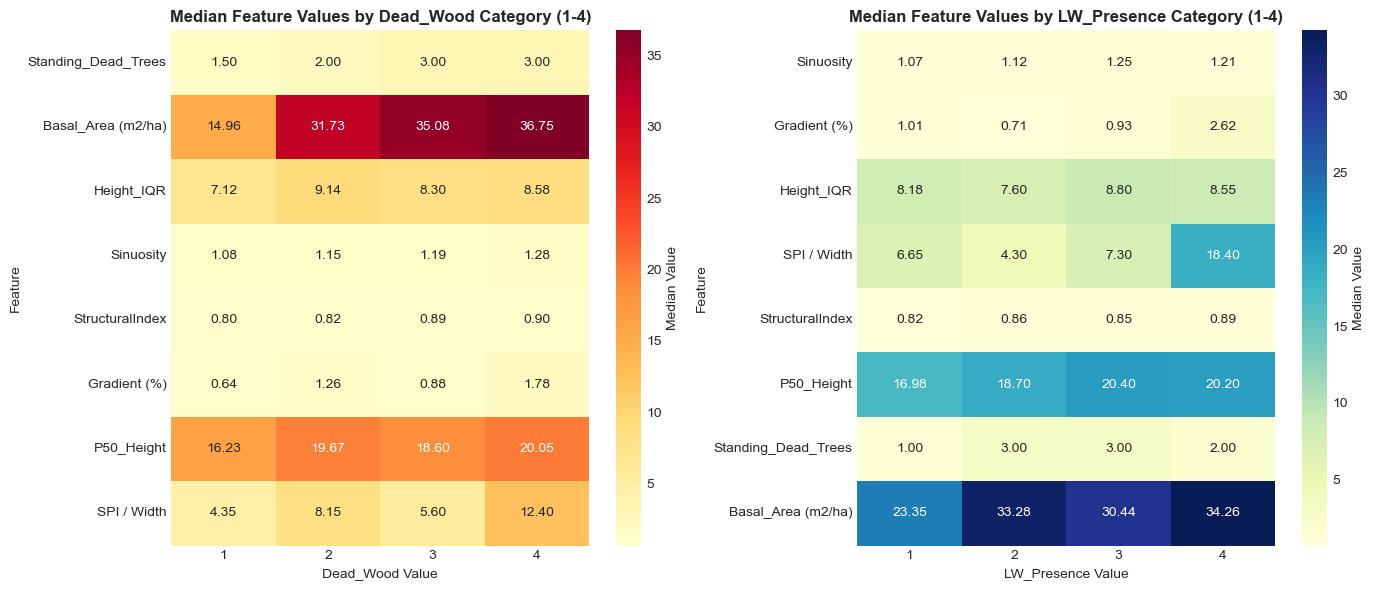

In [497]:
# Create heatmaps showing median values for better comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Dead_Wood heatmap
dead_wood_medians = df_dead_wood.groupby('Dead_Wood_Category')[top_8_features_dw].median()
sns.heatmap(dead_wood_medians.T, annot=True, fmt='.2f', cmap='YlOrRd', 
            ax=axes[0], cbar_kws={'label': 'Median Value'})
axes[0].set_title('Median Feature Values by Dead_Wood Category (1-4)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Dead_Wood Value')
axes[0].set_ylabel('Feature')

# LW_Presence heatmap
lw_medians = df_lw.groupby('LW_Presence_Category')[top_8_features_lw].median()
sns.heatmap(lw_medians.T, annot=True, fmt='.2f', cmap='YlGnBu', 
            ax=axes[1], cbar_kws={'label': 'Median Value'})
axes[1].set_title('Median Feature Values by LW_Presence Category (1-4)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('LW_Presence Value')
axes[1].set_ylabel('Feature')

plt.tight_layout()
plt.show()

### Interpretation: Key Ranges and Thresholds

In [498]:
print("\n" + "="*80)
print("INTERPRETATION: Feature Value Ranges Associated with Target Categories")
print("="*80)

print("\n--- DEAD WOOD ANALYSIS ---")
for target_val in [1, 2, 3, 4]:
    print(f"\nDead_Wood = {target_val}:")
    subset = df_dead_wood[df_dead_wood['Dead_Wood_Category'] == str(target_val)]
    print(f"  Sample size: {len(subset)}")
    for feat in top_8_features_dw:
        feat_data = subset[feat].dropna()
        if len(feat_data) > 0:
            print(f"  {feat}: [{feat_data.min():.2f} - {feat_data.max():.2f}] (mean: {feat_data.mean():.2f})")

print("\n--- LARGE WOOD PRESENCE ANALYSIS ---")
for target_val in [1, 2, 3, 4]:
    print(f"\nLW_Presence = {target_val}:")
    subset = df_lw[df_lw['LW_Presence_Category'] == str(target_val)]
    print(f"  Sample size: {len(subset)}")
    for feat in top_8_features_lw:
        feat_data = subset[feat].dropna()
        if len(feat_data) > 0:
            print(f"  {feat}: [{feat_data.min():.2f} - {feat_data.max():.2f}] (mean: {feat_data.mean():.2f})")


INTERPRETATION: Feature Value Ranges Associated with Target Categories

--- DEAD WOOD ANALYSIS ---

Dead_Wood = 1:
  Sample size: 10
  Standing_Dead_Trees: [1.00 - 2.00] (mean: 1.50)
  Basal_Area (m2/ha): [6.20 - 26.15] (mean: 16.18)
  Height_IQR: [5.10 - 8.50] (mean: 6.82)
  Sinuosity: [1.04 - 2.08] (mean: 1.29)
  StructuralIndex: [0.64 - 0.91] (mean: 0.80)
  Gradient (%): [0.21 - 1.59] (mean: 0.73)
  P50_Height: [9.90 - 25.20] (mean: 17.48)
  SPI / Width: [1.30 - 12.30] (mean: 6.13)

Dead_Wood = 2:
  Sample size: 22
  Standing_Dead_Trees: [1.00 - 3.00] (mean: 1.91)
  Basal_Area (m2/ha): [20.95 - 45.95] (mean: 30.96)
  Height_IQR: [5.20 - 12.50] (mean: 9.02)
  Sinuosity: [1.06 - 1.48] (mean: 1.20)
  StructuralIndex: [0.71 - 0.92] (mean: 0.82)
  Gradient (%): [0.21 - 3.60] (mean: 1.44)
  P50_Height: [13.30 - 24.80] (mean: 19.58)
  SPI / Width: [1.30 - 45.60] (mean: 11.14)

Dead_Wood = 3:
  Sample size: 29
  Standing_Dead_Trees: [2.00 - 4.00] (mean: 2.86)
  Basal_Area (m2/ha): [15.60 -

## 10. Feature Combinations: Multi-Variable Interactions

This section explores **combinations of variables** and how different feature ranges work together to produce target values.

**Key Questions:**
- Which **combinations** of features best characterize each target value?
- Are there synergistic effects where two features together are more predictive than either alone?
- What feature "profiles" distinguish target categories?

**Visualizations:**
- **Parallel Coordinates:** Show how multiple features combine and flow to each target value
- **2D Heatmaps:** Show joint distributions of pairs of top features and their relationship to targets
- **Pairwise Scatter:** All top feature pairs colored by target value to see joint patterns
- **3D Scatter:** Show 3-way feature combinations and target relationships

Features used for parallel coordinates:
  Dead_Wood: ['Standing_Dead_Trees', 'Basal_Area (m2/ha)', 'Height_IQR', 'Sinuosity', 'StructuralIndex', 'Gradient (%)', 'P50_Height', 'SPI / Width']
  LW_Presence: ['Sinuosity', 'Gradient (%)', 'Height_IQR', 'SPI / Width', 'StructuralIndex', 'P50_Height', 'Standing_Dead_Trees', 'Basal_Area (m2/ha)']



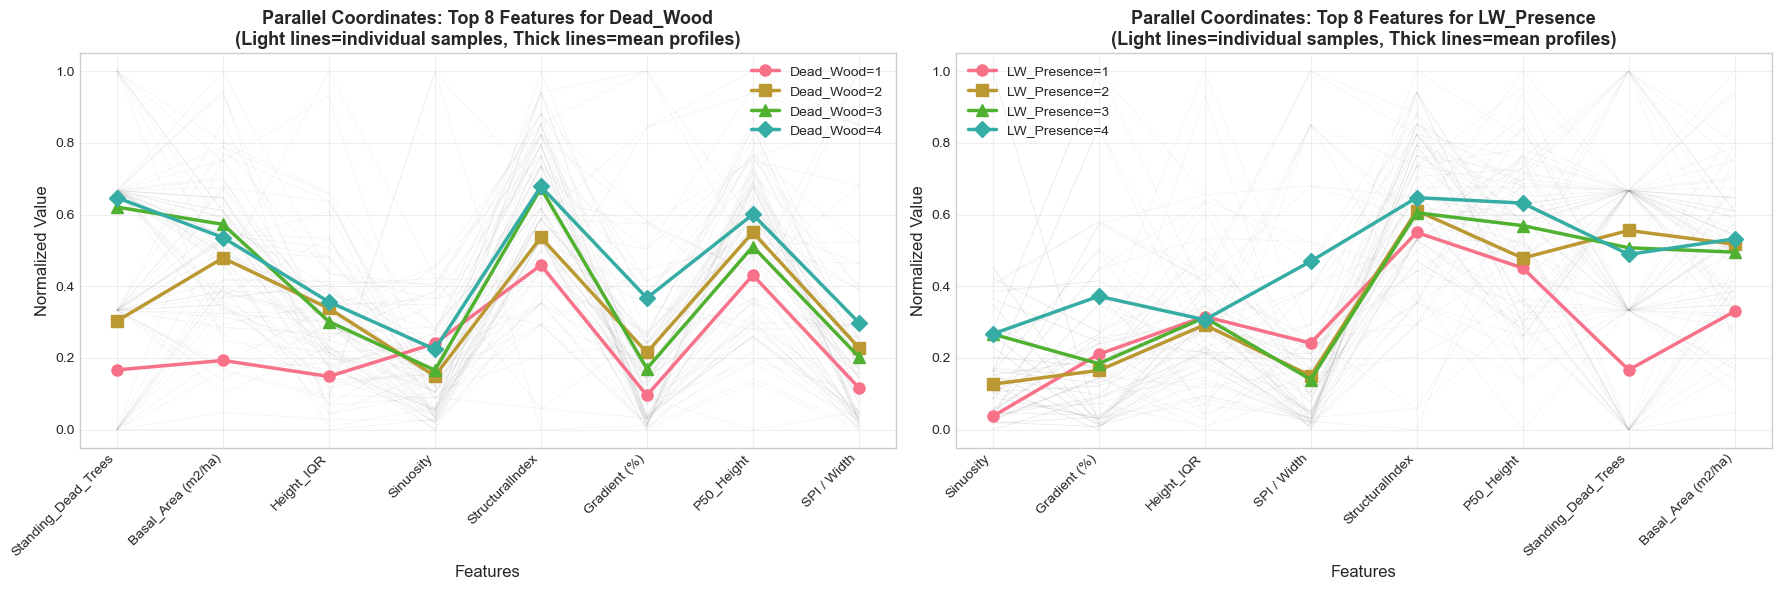


Parallel Coordinates Notes:
- Each line represents one sample
- Thick lines show mean values for each category
- Marker symbols: 1=circle (o), 2=square (s), 3=triangle (^), 4=diamond (D)
- Shows how features vary together across the target variable categories
- Dead_Wood using top 8 features: ['Standing_Dead_Trees', 'Basal_Area (m2/ha)', 'Height_IQR', 'Sinuosity', 'StructuralIndex', 'Gradient (%)', 'P50_Height', 'SPI / Width']
- LW_Presence using top 8 features: ['Sinuosity', 'Gradient (%)', 'Height_IQR', 'SPI / Width', 'StructuralIndex', 'P50_Height', 'Standing_Dead_Trees', 'Basal_Area (m2/ha)']


In [499]:
# Parallel Coordinates Plot - Dead_Wood and LW_Presence
# Import MinMaxScaler (needed for normalization)
from sklearn.preprocessing import MinMaxScaler

# Select top 8 features for EACH target variable (calculated previously)
top_8_features_for_dw = top_8_features_dw[:8]  # Top 8 features specifically for Dead_Wood
top_8_features_for_lw = top_8_features_lw[:8]  # Top 8 features specifically for LW_Presence

print("Features used for parallel coordinates:")
print(f"  Dead_Wood: {top_8_features_for_dw}")
print(f"  LW_Presence: {top_8_features_for_lw}\n")

# Prepare Dead_Wood data with Dead_Wood's top 8 features
prep_data_dw = df_dead_wood[top_8_features_for_dw + ['Dead_Wood_Category']].dropna()
scaler_dw = MinMaxScaler()
prep_data_normalized_dw = prep_data_dw.copy()
prep_data_normalized_dw[top_8_features_for_dw] = scaler_dw.fit_transform(prep_data_dw[top_8_features_for_dw])

# Prepare LW_Presence data with LW_Presence's top 8 features
prep_data_lw = df_lw[top_8_features_for_lw + ['LW_Presence_Category']].dropna()
scaler_lw = MinMaxScaler()
prep_data_normalized_lw = prep_data_lw.copy()
prep_data_normalized_lw[top_8_features_for_lw] = scaler_lw.fit_transform(prep_data_lw[top_8_features_for_lw])

# Create parallel coordinates plots for both target variables
# Define marker mapping for consistency across both graphs (1=circle, 2=square, 3=triangle, 4=diamond)
markers = {1: 'o', 2: 's', 3: '^', 4: 'D'}

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

data_sets = [
    ('Dead_Wood', prep_data_normalized_dw, 'Dead_Wood_Category', top_8_features_for_dw),
    ('LW_Presence', prep_data_normalized_lw, 'LW_Presence_Category', top_8_features_for_lw)
]

for idx, (target_name, data, category_col, features) in enumerate(data_sets):
    ax = axes[idx]
    
## no change
    # Plot individual samples (light lines)
    for _, row in data.iterrows():
        positions = np.arange(len(features))
        values = [row[feat] for feat in features]
        ax.plot(positions, values, alpha=0.1, color='gray', linewidth=0.5)
    
    # Plot mean profiles (thick lines)
    for category in sorted(data[category_col].unique()):
        subset = data[data[category_col] == category]
        positions = np.arange(len(features))
        mean_values = [subset[feat].mean() for feat in features]
        ax.plot(positions, mean_values, linewidth=2.5, marker=markers[int(category)], label=f'{target_name}={int(category)}', markersize=8)
    
    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Normalized Value', fontsize=12)
    ax.set_title(f'Parallel Coordinates: Top 8 Features for {target_name}\n(Light lines=individual samples, Thick lines=mean profiles)', 
                fontsize=13, fontweight='bold')
    ax.set_xticks(np.arange(len(features)))
    ax.set_xticklabels(features, rotation=45, ha='right')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print("\nParallel Coordinates Notes:")
print("- Each line represents one sample")
print("- Thick lines show mean values for each category")
print("- Marker symbols: 1=circle (o), 2=square (s), 3=triangle (^), 4=diamond (D)")
print("- Shows how features vary together across the target variable categories")
print(f"- Dead_Wood using top 8 features: {top_8_features_for_dw}")
print(f"- LW_Presence using top 8 features: {top_8_features_for_lw}")

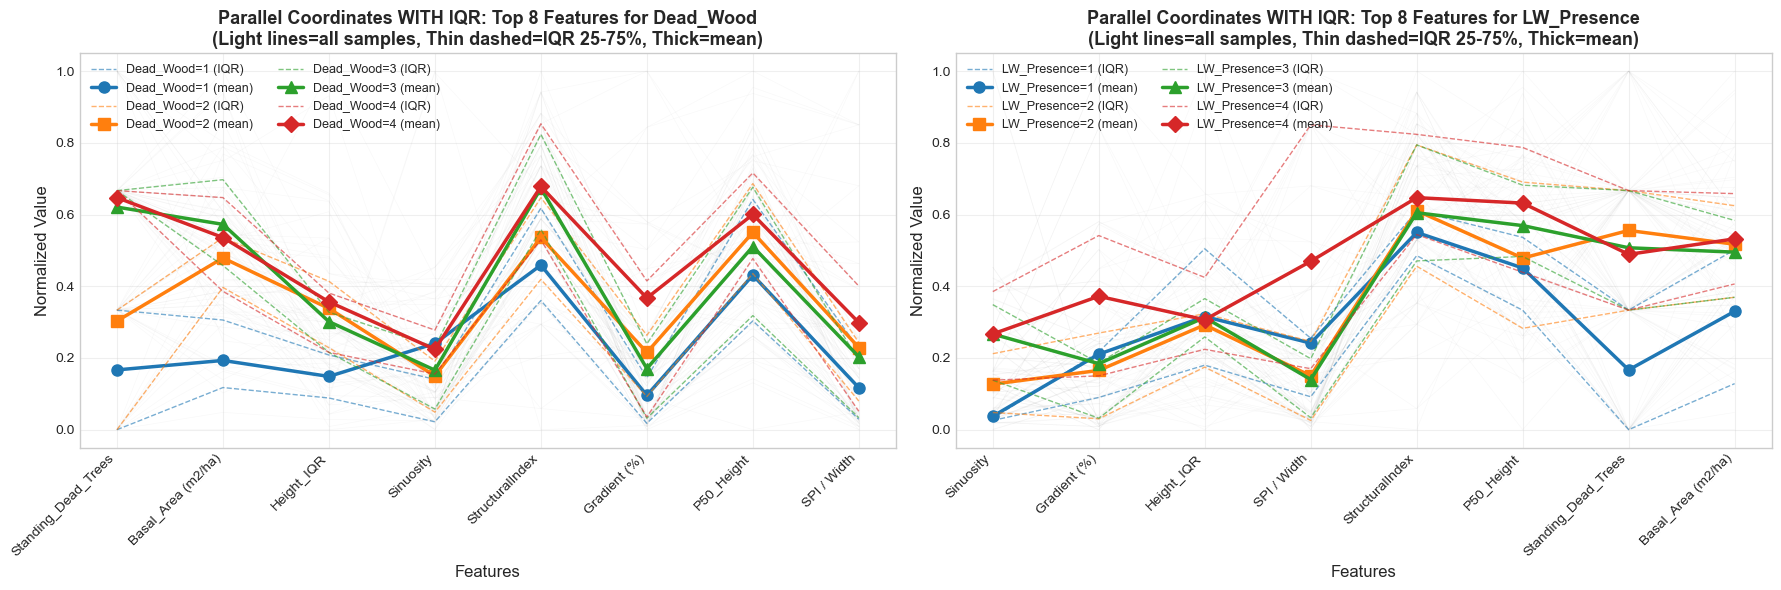


Parallel Coordinates WITH IQR Lines:
- Light gray lines: Individual samples
- Thin dashed lines: 25th and 75th percentile bounds (same color as mean)
- Thick lines: Mean values for each category
- Marker symbols: 1=circle (o), 2=square (s), 3=triangle (^), 4=diamond (D)


In [500]:
# Parallel Coordinates Plot WITH IQR BANDS - Dead_Wood and LW_Presence
# Same as above but includes IQR (25-75%) as thin lines (no fill) in same color as mean

markers = {1: 'o', 2: 's', 3: '^', 4: 'D'}
# Define colors for consistency (using standard matplotlib colors)
colors = {1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c', 4: '#d62728'}

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

data_sets = [
    ('Dead_Wood', prep_data_normalized_dw, 'Dead_Wood_Category', top_8_features_for_dw),
    ('LW_Presence', prep_data_normalized_lw, 'LW_Presence_Category', top_8_features_for_lw)
]

for idx, (target_name, data, category_col, features) in enumerate(data_sets):
    ax = axes[idx]
    
    # Plot individual samples (light lines)
    for _, row in data.iterrows():
        positions = np.arange(len(features))
        values = [row[feat] for feat in features]
        ax.plot(positions, values, alpha=0.05, color='gray', linewidth=0.5)
    
    # Plot mean profiles with IQR thin lines
    for category in sorted(data[category_col].unique()):
        subset = data[data[category_col] == category]
        positions = np.arange(len(features))
        
        # Calculate mean and IQR for each feature
        mean_values = []
        q25_values = []
        q75_values = []
        
        for feat in features:
            mean_values.append(subset[feat].mean())
            q25_values.append(subset[feat].quantile(0.25))
            q75_values.append(subset[feat].quantile(0.75))
        
        cat_int = int(category)
        cat_color = colors[cat_int]
        
        # Plot Q25 and Q75 as thin lines with same color as mean
        ax.plot(positions, q25_values, linewidth=1, color=cat_color, alpha=0.6, linestyle='--')
        ax.plot(positions, q75_values, linewidth=1, color=cat_color, alpha=0.6, linestyle='--', label=f'{target_name}={cat_int} (IQR)')
        
        # Plot mean line on top with distinct marker per category
        ax.plot(positions, mean_values, linewidth=2.5, marker=markers[cat_int], 
                label=f'{target_name}={cat_int} (mean)', markersize=8, color=cat_color)
    
    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Normalized Value', fontsize=12)
    ax.set_title(f'Parallel Coordinates WITH IQR: Top 8 Features for {target_name}\n(Light lines=all samples, Thin dashed=IQR 25-75%, Thick=mean)', 
                fontsize=13, fontweight='bold')
    ax.set_xticks(np.arange(len(features)))
    ax.set_xticklabels(features, rotation=45, ha='right')
    ax.legend(fontsize=9, loc='upper left', ncol=2)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print("\nParallel Coordinates WITH IQR Lines:")
print("- Light gray lines: Individual samples")
print("- Thin dashed lines: 25th and 75th percentile bounds (same color as mean)")
print("- Thick lines: Mean values for each category")
print("- Marker symbols: 1=circle (o), 2=square (s), 3=triangle (^), 4=diamond (D)")

Dead_Wood: Top 8 Features
  1. Standing_Dead_Trees
  2. Basal_Area (m2/ha)
  3. Height_IQR
  4. Sinuosity
  5. StructuralIndex


C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_28300\778875256.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  contingency = data_subset.groupby([feat1_bins, feat2_bins])[target_col].agg(['mean', 'count'])
C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_28300\778875256.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  contingency = data_subset.groupby([feat1_bins, feat2_bins])[target_col].agg(['mean', 'count'])
C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_28300\778875256.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass o

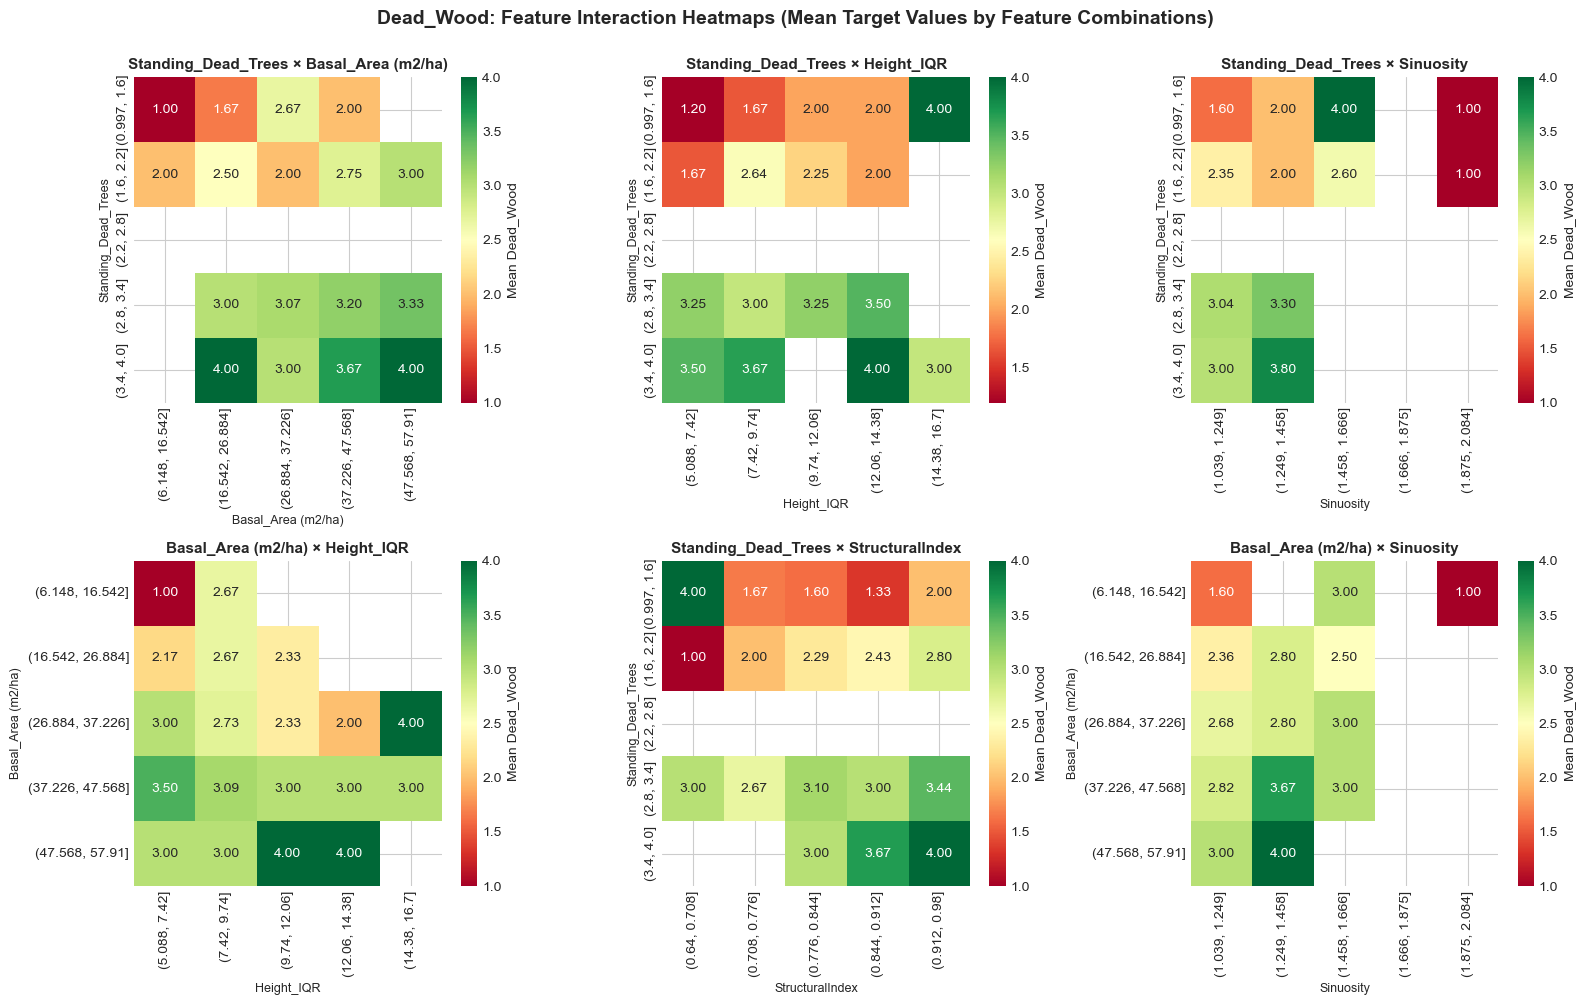



LW_Presence: Top 8 Features
  1. Sinuosity
  2. Gradient (%)
  3. Height_IQR
  4. SPI / Width
  5. StructuralIndex


C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_28300\778875256.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  contingency = data_subset.groupby([feat1_bins, feat2_bins])[target_col].agg(['mean', 'count'])
C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_28300\778875256.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  contingency = data_subset.groupby([feat1_bins, feat2_bins])[target_col].agg(['mean', 'count'])
C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_28300\778875256.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass o

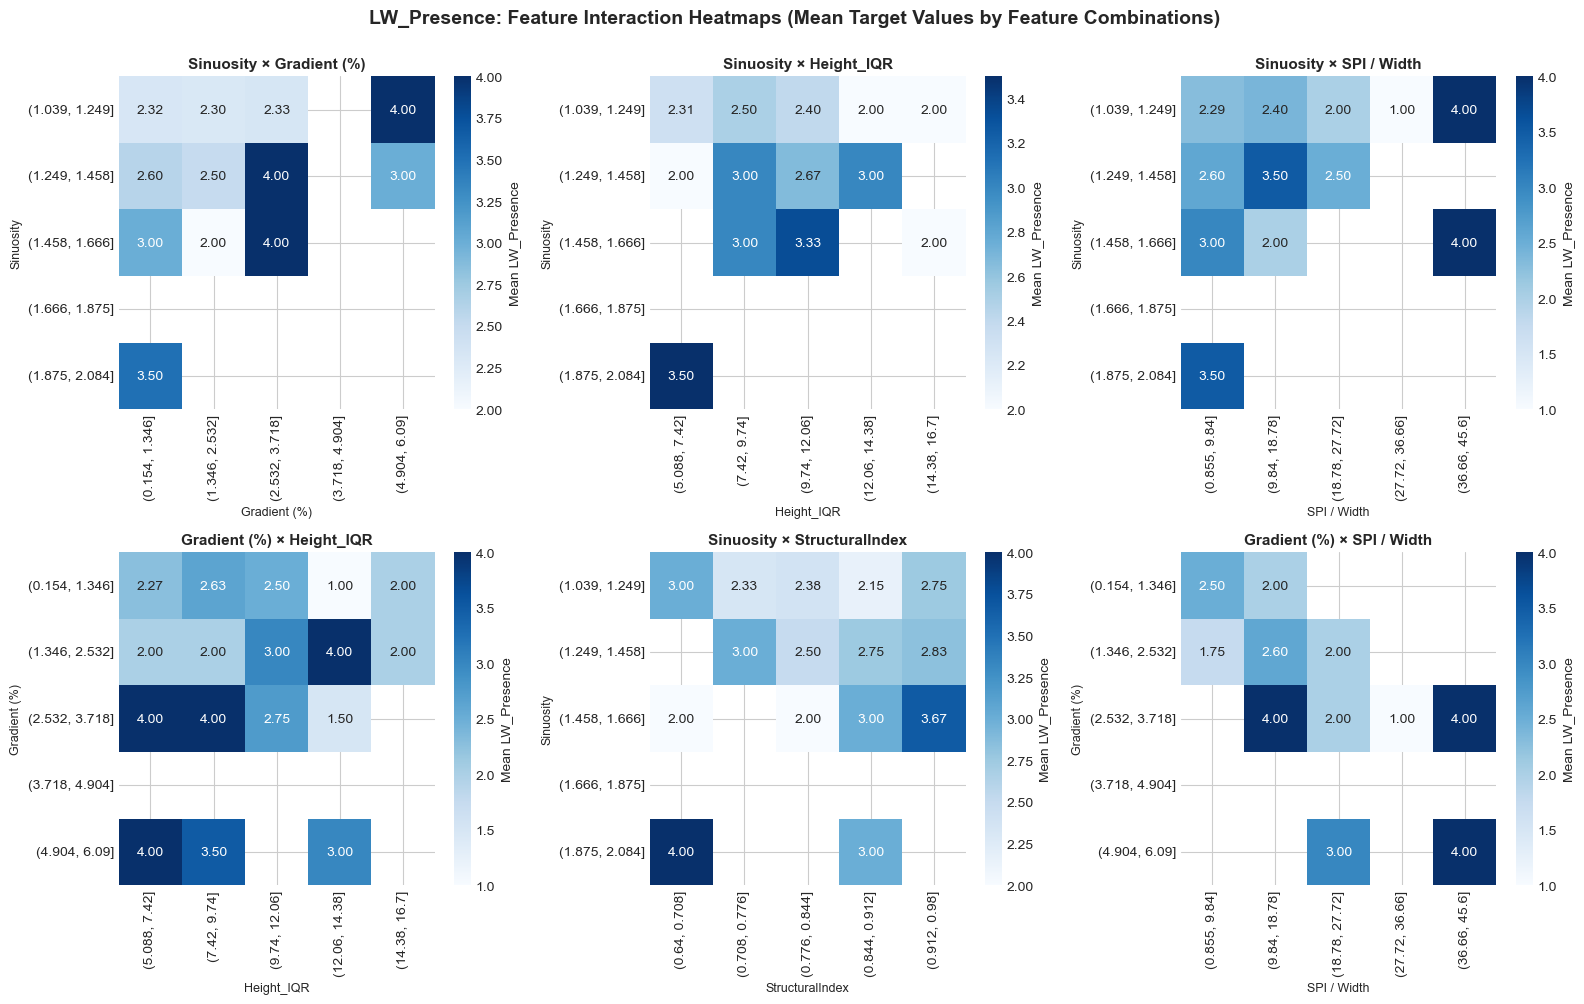


Interpretation: Each heatmap shows how two features interact to predict the target value.
Brighter colors = higher target values. Look for diagonal or off-diagonal patterns.
Cells with few samples are less reliable (visible as gaps in the grid).


In [501]:
# 2D Heatmaps: 6 Feature Pair Combinations for each Target Variable
# Show how target value distribution changes with different feature combinations
# Feature pairs: 1-2, 1-3, 1-4, 2-3, 1-5, 2-4

n_bins = 5

# Helper function to create heatmap
def create_feature_heatmap(data, feat1, feat2, target_col, target_name, ax, cmap='RdYlGn'):
    """Create a heatmap for two feature combinations"""
    data_subset = data[[feat1, feat2, target_col]].dropna()
    
    if len(data_subset) == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        return
    
    feat1_bins = pd.cut(data_subset[feat1], bins=n_bins)
    feat2_bins = pd.cut(data_subset[feat2], bins=n_bins)
    
    contingency = data_subset.groupby([feat1_bins, feat2_bins])[target_col].agg(['mean', 'count'])
    pivot = contingency['mean'].unstack()
    
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap=cmap, ax=ax,
                cbar_kws={'label': f'Mean {target_name}'})
    ax.set_title(f'{feat1} × {feat2}', fontsize=11, fontweight='bold')
    ax.set_xlabel(feat2, fontsize=9)
    ax.set_ylabel(feat1, fontsize=9)

# ============= DEAD_WOOD: 6 Feature Pairs =============
print("Dead_Wood: Top 8 Features")
print(f"  1. {top_8_features_dw[0]}")
print(f"  2. {top_8_features_dw[1]}")
print(f"  3. {top_8_features_dw[2]}")
print(f"  4. {top_8_features_dw[3]}")
print(f"  5. {top_8_features_dw[4]}")

fig_dw, axes_dw = plt.subplots(2, 3, figsize=(16, 10))
axes_dw = axes_dw.flatten()

# Feature pairs for Dead_Wood: 1-2, 1-3, 1-4, 2-3, 1-5, 2-4
feature_pairs_dw = [
    (top_8_features_dw[0], top_8_features_dw[1], 'Features 1-2'),
    (top_8_features_dw[0], top_8_features_dw[2], 'Features 1-3'),
    (top_8_features_dw[0], top_8_features_dw[3], 'Features 1-4'),
    (top_8_features_dw[1], top_8_features_dw[2], 'Features 2-3'),
    (top_8_features_dw[0], top_8_features_dw[4], 'Features 1-5'),
    (top_8_features_dw[1], top_8_features_dw[3], 'Features 2-4'),
]

for idx, (feat1, feat2, label) in enumerate(feature_pairs_dw):
    create_feature_heatmap(df_dead_wood, feat1, feat2, 'Dead_Wood', 'Dead_Wood', 
                          axes_dw[idx], cmap='RdYlGn')

fig_dw.suptitle('Dead_Wood: Feature Interaction Heatmaps (Mean Target Values by Feature Combinations)', 
                 fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# ============= LW_PRESENCE: 6 Feature Pairs =============
print("\n\nLW_Presence: Top 8 Features")
print(f"  1. {top_8_features_lw[0]}")
print(f"  2. {top_8_features_lw[1]}")
print(f"  3. {top_8_features_lw[2]}")
print(f"  4. {top_8_features_lw[3]}")
print(f"  5. {top_8_features_lw[4]}")

fig_lw, axes_lw = plt.subplots(2, 3, figsize=(16, 10))
axes_lw = axes_lw.flatten()

# Feature pairs for LW_Presence: 1-2, 1-3, 1-4, 2-3, 1-5, 2-4
feature_pairs_lw = [
    (top_8_features_lw[0], top_8_features_lw[1], 'Features 1-2'),
    (top_8_features_lw[0], top_8_features_lw[2], 'Features 1-3'),
    (top_8_features_lw[0], top_8_features_lw[3], 'Features 1-4'),
    (top_8_features_lw[1], top_8_features_lw[2], 'Features 2-3'),
    (top_8_features_lw[0], top_8_features_lw[4], 'Features 1-5'),
    (top_8_features_lw[1], top_8_features_lw[3], 'Features 2-4'),
]

for idx, (feat1, feat2, label) in enumerate(feature_pairs_lw):
    create_feature_heatmap(df_lw, feat1, feat2, 'LW_Presence', 'LW_Presence', 
                          axes_lw[idx], cmap='Blues')

fig_lw.suptitle('LW_Presence: Feature Interaction Heatmaps (Mean Target Values by Feature Combinations)', 
                 fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"\nInterpretation: Each heatmap shows how two features interact to predict the target value.")
print(f"Brighter colors = higher target values. Look for diagonal or off-diagonal patterns.")
print(f"Cells with few samples are less reliable (visible as gaps in the grid).")

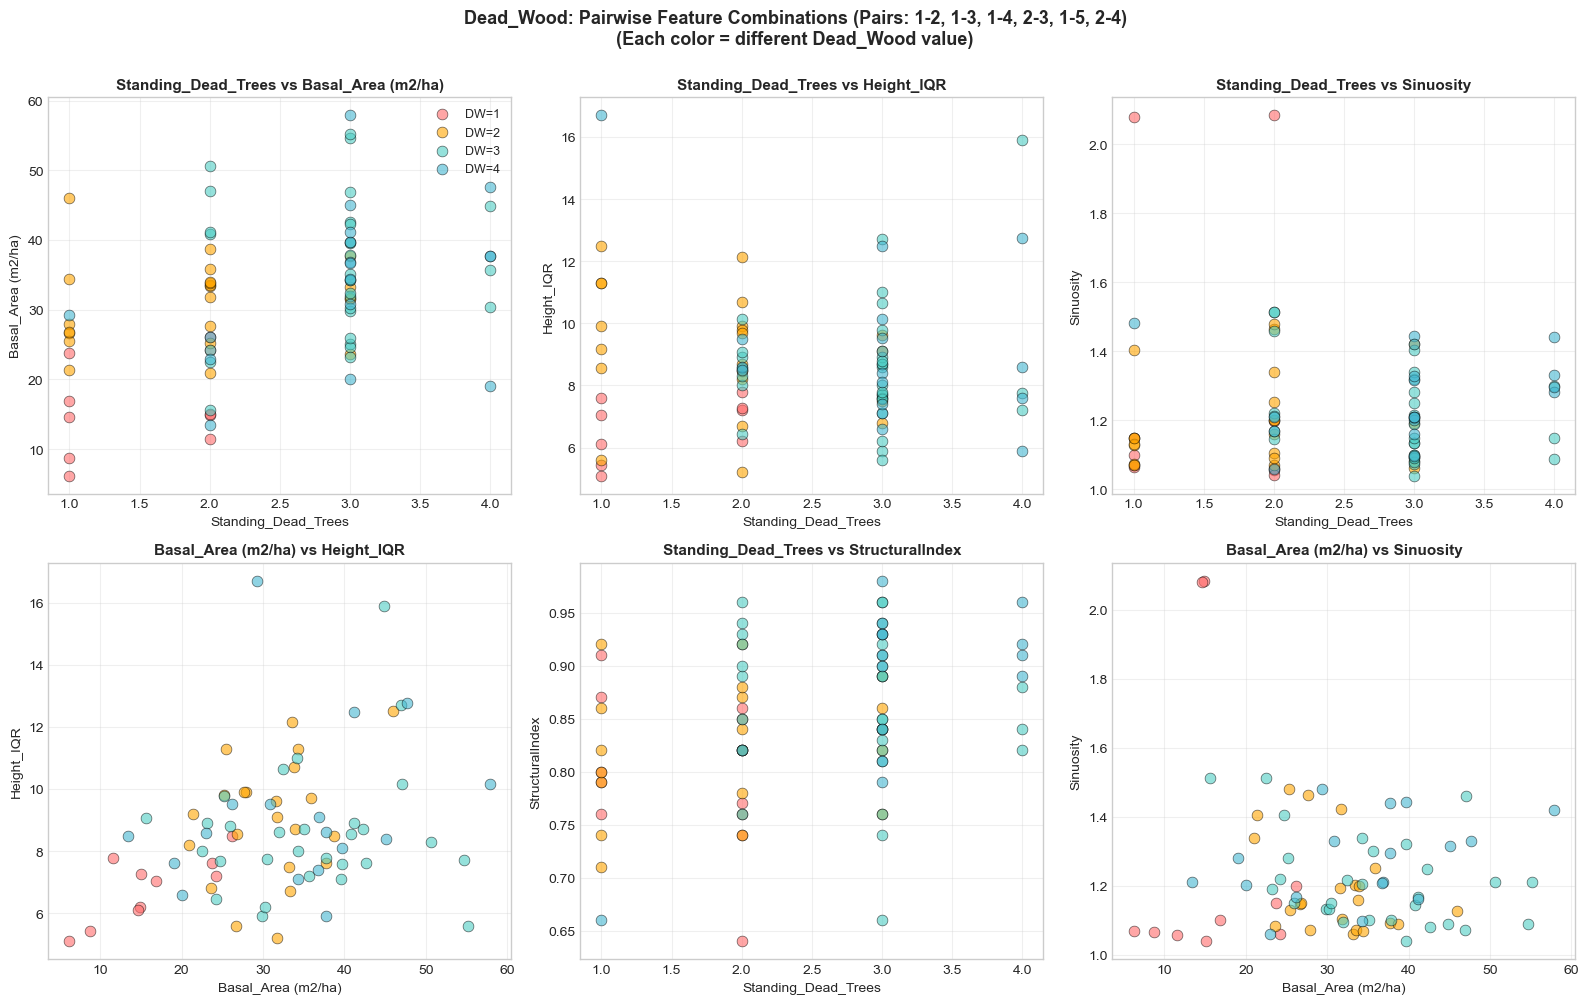

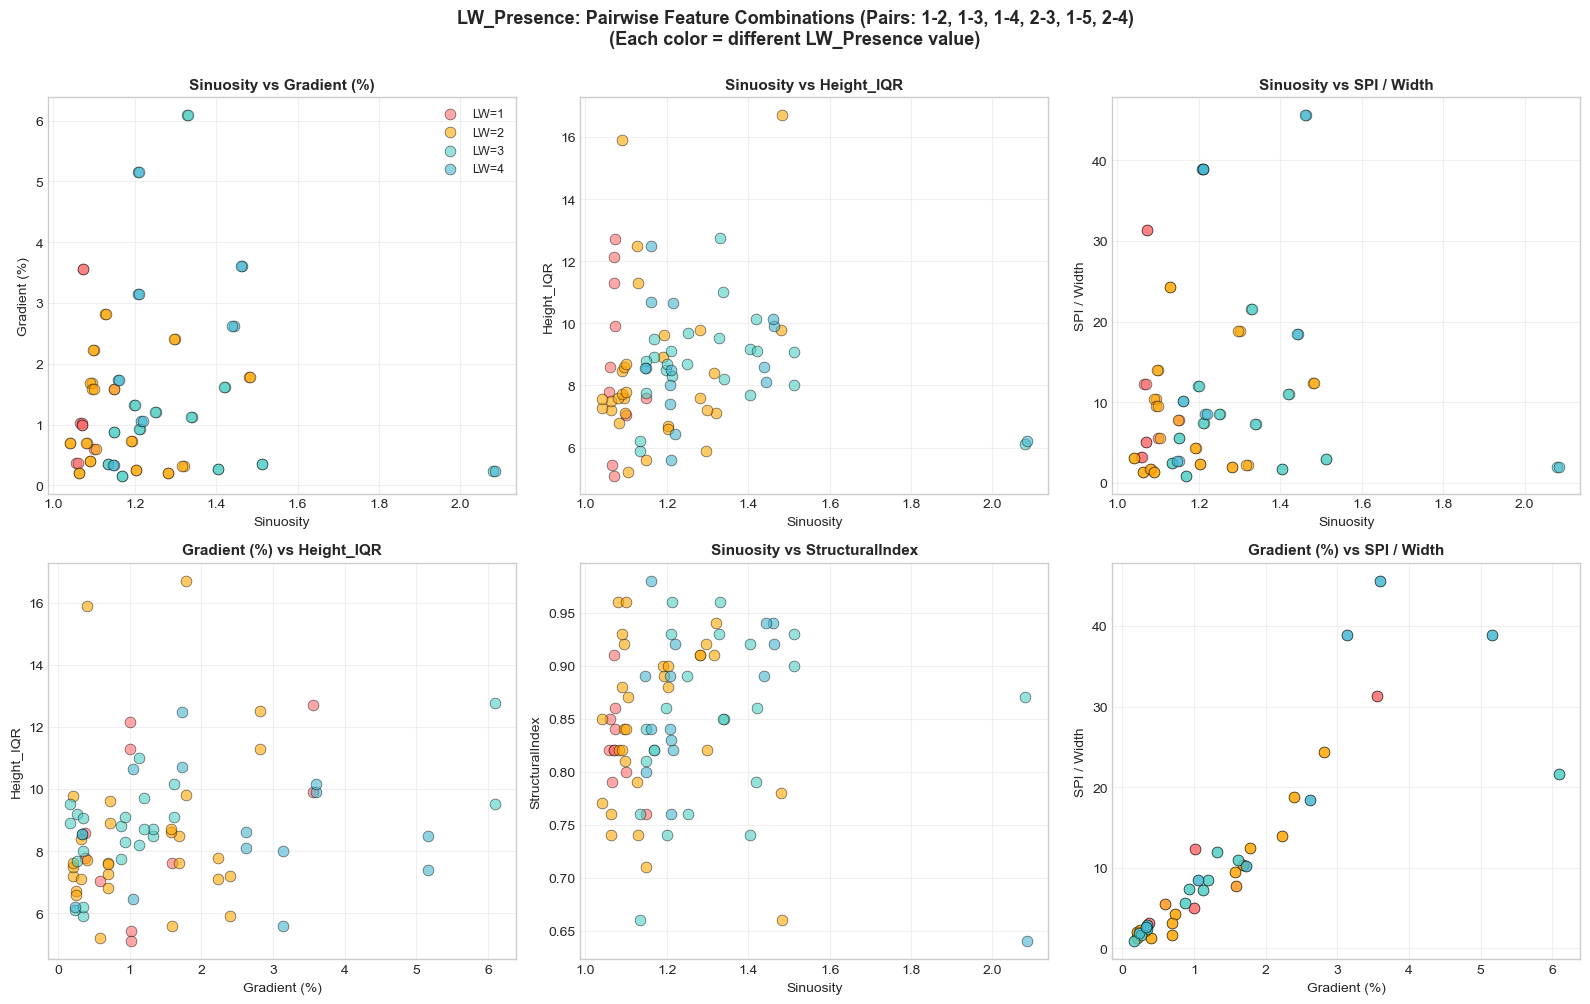


Interpretation: Each colored cluster represents samples with a specific target value.
Pairs are now consistent with the heatmaps: 1-2, 1-3, 1-4, 2-3, 1-5, 2-4
If clusters are well-separated, those feature combinations are predictive of the target.


In [502]:
# Pairwise Scatter Plots - Specific feature pair combinations (1-2, 1-3, 1-4, 2-3, 1-5, 2-4)
# Colored by target value to see which combinations lead to which targets

# ============= DEAD_WOOD: 6 Feature Pairs =============
# Prepare data with top 5 features (subset needed for the 6 feature pairs)
top_5_dw_features = top_8_features_dw[:5]
top_5_dw_data = df_dead_wood[top_5_dw_features + ['Dead_Wood_Category']].dropna()

# Define the 6 feature pair combinations: 1-2, 1-3, 1-4, 2-3, 1-5, 2-4
feature_pairs_dw = [
    (top_8_features_dw[0], top_8_features_dw[1]),
    (top_8_features_dw[0], top_8_features_dw[2]),
    (top_8_features_dw[0], top_8_features_dw[3]),
    (top_8_features_dw[1], top_8_features_dw[2]),
    (top_8_features_dw[0], top_8_features_dw[4]),
    (top_8_features_dw[1], top_8_features_dw[3]),
]

fig_dw, axes_dw = plt.subplots(2, 3, figsize=(16, 10))
axes_dw = axes_dw.flatten()

colors_map = {'1': '#FF6B6B', '2': '#FFA500', '3': '#4ECDC4', '4': '#45B7D1'}

for idx, (feat1, feat2) in enumerate(feature_pairs_dw):
    ax = axes_dw[idx]
    for target_val in ['1', '2', '3', '4']:
        subset = top_5_dw_data[top_5_dw_data['Dead_Wood_Category'] == target_val]
        ax.scatter(subset[feat1], subset[feat2], label=f'DW={target_val}', 
                  alpha=0.6, s=60, color=colors_map[target_val], edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel(feat1, fontsize=10)
    ax.set_ylabel(feat2, fontsize=10)
    ax.set_title(f'{feat1} vs {feat2}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    if idx == 0:
        ax.legend(loc='best', fontsize=9)

fig_dw.suptitle('Dead_Wood: Pairwise Feature Combinations (Pairs: 1-2, 1-3, 1-4, 2-3, 1-5, 2-4)\n(Each color = different Dead_Wood value)', 
             fontsize=13, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# ============= LW_PRESENCE: 6 Feature Pairs =============
# Prepare data with top 5 features
top_5_lw_features = top_8_features_lw[:5]
top_5_lw_data = df_lw[top_5_lw_features + ['LW_Presence_Category']].dropna()

# Define the same 6 feature pair combinations: 1-2, 1-3, 1-4, 2-3, 1-5, 2-4
feature_pairs_lw = [
    (top_8_features_lw[0], top_8_features_lw[1]),
    (top_8_features_lw[0], top_8_features_lw[2]),
    (top_8_features_lw[0], top_8_features_lw[3]),
    (top_8_features_lw[1], top_8_features_lw[2]),
    (top_8_features_lw[0], top_8_features_lw[4]),
    (top_8_features_lw[1], top_8_features_lw[3]),
]

fig_lw, axes_lw = plt.subplots(2, 3, figsize=(16, 10))
axes_lw = axes_lw.flatten()

for idx, (feat1, feat2) in enumerate(feature_pairs_lw):
    ax = axes_lw[idx]
    for target_val in ['1', '2', '3', '4']:
        subset = top_5_lw_data[top_5_lw_data['LW_Presence_Category'] == target_val]
        ax.scatter(subset[feat1], subset[feat2], label=f'LW={target_val}', 
                  alpha=0.6, s=60, color=colors_map[target_val], edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel(feat1, fontsize=10)
    ax.set_ylabel(feat2, fontsize=10)
    ax.set_title(f'{feat1} vs {feat2}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    if idx == 0:
        ax.legend(loc='best', fontsize=9)

fig_lw.suptitle('LW_Presence: Pairwise Feature Combinations (Pairs: 1-2, 1-3, 1-4, 2-3, 1-5, 2-4)\n(Each color = different LW_Presence value)', 
             fontsize=13, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"\nInterpretation: Each colored cluster represents samples with a specific target value.")
print(f"Pairs are now consistent with the heatmaps: 1-2, 1-3, 1-4, 2-3, 1-5, 2-4")
print(f"If clusters are well-separated, those feature combinations are predictive of the target.")

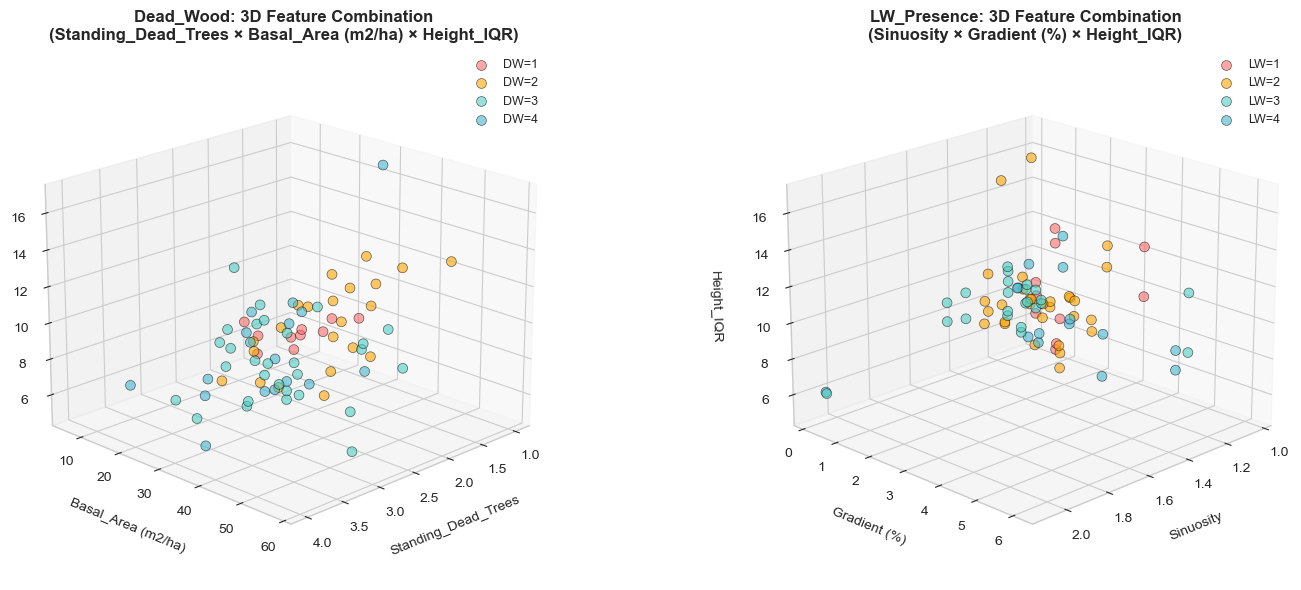


Interpretation: This 3D view shows how three features together determine the target value.
Well-separated colored clusters indicate that this 3-way combination is highly predictive.


In [503]:
# 3D Scatter Plots - Three-way feature interactions
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 6))

# Dead_Wood: 3D plot with top 3 features
ax1 = fig.add_subplot(121, projection='3d')
top_3_dw = top_8_features_dw[:3]
data_3d_dw = df_dead_wood[top_3_dw + ['Dead_Wood_Category']].dropna()

for target_val, color in zip(['1', '2', '3', '4'], ['#FF6B6B', '#FFA500', '#4ECDC4', '#45B7D1']):
    subset = data_3d_dw[data_3d_dw['Dead_Wood_Category'] == target_val]
    ax1.scatter(subset[top_3_dw[0]], subset[top_3_dw[1]], subset[top_3_dw[2]], 
               label=f'DW={target_val}', alpha=0.6, s=50, color=color, edgecolors='black', linewidth=0.5)

ax1.set_xlabel(top_3_dw[0], fontsize=10, labelpad=10)
ax1.set_ylabel(top_3_dw[1], fontsize=10, labelpad=10)
ax1.set_zlabel(top_3_dw[2], fontsize=10, labelpad=10)
ax1.set_title(f'Dead_Wood: 3D Feature Combination\n({top_3_dw[0]} × {top_3_dw[1]} × {top_3_dw[2]})', 
             fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.view_init(elev=20, azim=45)

# LW_Presence: 3D plot with top 3 features
ax2 = fig.add_subplot(122, projection='3d')
top_3_lw = top_8_features_lw[:3]
data_3d_lw = df_lw[top_3_lw + ['LW_Presence_Category']].dropna()

for target_val, color in zip(['1', '2', '3', '4'], ['#FF6B6B', '#FFA500', '#4ECDC4', '#45B7D1']):
    subset = data_3d_lw[data_3d_lw['LW_Presence_Category'] == target_val]
    ax2.scatter(subset[top_3_lw[0]], subset[top_3_lw[1]], subset[top_3_lw[2]], 
               label=f'LW={target_val}', alpha=0.6, s=50, color=color, edgecolors='black', linewidth=0.5)

ax2.set_xlabel(top_3_lw[0], fontsize=10, labelpad=10)
ax2.set_ylabel(top_3_lw[1], fontsize=10, labelpad=10)
ax2.set_zlabel(top_3_lw[2], fontsize=10, labelpad=10)
ax2.set_title(f'LW_Presence: 3D Feature Combination\n({top_3_lw[0]} × {top_3_lw[1]} × {top_3_lw[2]})', 
             fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', fontsize=9)
ax2.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

print(f"\nInterpretation: This 3D view shows how three features together determine the target value.")
print(f"Well-separated colored clusters indicate that this 3-way combination is highly predictive.")

In [504]:
# Feature Interaction Summary: Identify key combinations
print("\n" + "="*80)
print("SUMMARY: Key Feature Combinations and Interpretations")
print("="*80)

print("\n--- DEAD_WOOD: Best Feature Combinations ---")
print(f"\nPrimary Driver: {top_8_features_dw[0]} (Importance: {dw_importance[top_8_features_dw[0]]:.4f})")
print(f"Secondary Driver: {top_8_features_dw[1]} (Importance: {dw_importance[top_8_features_dw[1]]:.4f})")
print(f"Tertiary Factor: {top_8_features_dw[2]} (Importance: {dw_importance[top_8_features_dw[2]]:.4f})")

print(f"\nTop Feature Interaction Profiles for Dead_Wood:")
for target_val in [1, 2, 3, 4]:
    subset = df_dead_wood[df_dead_wood['Dead_Wood_Category'] == str(target_val)]
    if len(subset) > 0:
        print(f"\n  Dead_Wood = {target_val} (n={len(subset)} samples):")
        feat1_range = subset[top_8_features_dw[0]].agg(['min', 'mean', 'max'])
        feat2_range = subset[top_8_features_dw[1]].agg(['min', 'mean', 'max'])
        print(f"    {top_8_features_dw[0]}: [{feat1_range['min']:.2f} - {feat1_range['max']:.2f}] (mean: {feat1_range['mean']:.2f})")
        print(f"    {top_8_features_dw[1]}: [{feat2_range['min']:.2f} - {feat2_range['max']:.2f}] (mean: {feat2_range['mean']:.2f})")

print("\n" + "-"*80)
print("\n--- LW_PRESENCE: Best Feature Combinations ---")
print(f"\nPrimary Driver: {top_8_features_lw[0]} (Importance: {lw_importance[top_8_features_lw[0]]:.4f})")
print(f"Secondary Driver: {top_8_features_lw[1]} (Importance: {lw_importance[top_8_features_lw[1]]:.4f})")
print(f"Tertiary Factor: {top_8_features_lw[2]} (Importance: {lw_importance[top_8_features_lw[2]]:.4f})")

print(f"\nTop Feature Interaction Profiles for LW_Presence:")
for target_val in [1, 2, 3, 4]:
    subset = df_lw[df_lw['LW_Presence_Category'] == str(target_val)]
    if len(subset) > 0:
        print(f"\n  LW_Presence = {target_val} (n={len(subset)} samples):")
        feat1_range = subset[top_8_features_lw[0]].agg(['min', 'mean', 'max'])
        feat2_range = subset[top_8_features_lw[1]].agg(['min', 'mean', 'max'])
        print(f"    {top_8_features_lw[0]}: [{feat1_range['min']:.2f} - {feat1_range['max']:.2f}] (mean: {feat1_range['mean']:.2f})")
        print(f"    {top_8_features_lw[1]}: [{feat2_range['min']:.2f} - {feat2_range['max']:.2f}] (mean: {feat2_range['mean']:.2f})")

print("\n" + "="*80)
print("KEY INSIGHT:")
print("="*80)
print("""
The visualizations above reveal:

1. PARALLEL COORDINATES: Shows how individual samples flow through feature space
   - Thick mean lines show the "typical profile" for each target value
   - Well-separated profiles indicate strong predictability

2. 2D HEATMAPS: Show which combinations of two features are associated with high/low targets
   - Cells with both darker and higher values = strong feature combinations
   - These represent synergistic effects (not just additive)

3. PAIRWISE SCATTERS: Colored by target, show if feature pairs cleanly separate targets
   - Well-separated clusters = feature pair is predictive
   - Overlapping clusters = feature pair alone is insufficient

4. 3D SCATTER: Shows how three features together define target categories
   - Spatial clustering indicates feature combinations drive target values
   - Can be rotated to explore different viewing angles
""")


SUMMARY: Key Feature Combinations and Interpretations

--- DEAD_WOOD: Best Feature Combinations ---

Primary Driver: Standing_Dead_Trees (Importance: 0.2979)
Secondary Driver: Basal_Area (m2/ha) (Importance: 0.1476)
Tertiary Factor: Height_IQR (Importance: 0.1348)

Top Feature Interaction Profiles for Dead_Wood:

  Dead_Wood = 1 (n=10 samples):
    Standing_Dead_Trees: [1.00 - 2.00] (mean: 1.50)
    Basal_Area (m2/ha): [6.20 - 26.15] (mean: 16.18)

  Dead_Wood = 2 (n=22 samples):
    Standing_Dead_Trees: [1.00 - 3.00] (mean: 1.91)
    Basal_Area (m2/ha): [20.95 - 45.95] (mean: 30.96)

  Dead_Wood = 3 (n=29 samples):
    Standing_Dead_Trees: [2.00 - 4.00] (mean: 2.86)
    Basal_Area (m2/ha): [15.60 - 55.15] (mean: 35.81)

  Dead_Wood = 4 (n=17 samples):
    Standing_Dead_Trees: [1.00 - 4.00] (mean: 2.94)
    Basal_Area (m2/ha): [13.40 - 57.91] (mean: 33.91)

--------------------------------------------------------------------------------

--- LW_PRESENCE: Best Feature Combinations ---


In [505]:
# Inspect new CSV file: RV_For_RF2_n_1.csv
df_n_1 = pd.read_csv('data/RV_For_RF2_n_1.csv')
print(f"Shape: {df_n_1.shape}")
print(f"\nAll column names ({len(df_n_1.columns)} total):")
print(df_n_1.columns.tolist())

print(f"\n\n=== NEW COLUMNS ===")
new_cols = [col for col in df_n_1.columns if col.startswith('D_') or col.startswith('UP_') or 'Basin' in col or 'Bank' in col or 'Headwater' in col]
print(new_cols)

print(f"\n\n=== Basin values ===")
print(df_n_1['Basin'].unique() if 'Basin' in df_n_1.columns else 'Basin not found')

print(f"\n\n=== First few rows ===")
print(df_n_1.head(3))

FileNotFoundError: [Errno 2] No such file or directory: 'data/RV_For_RF2_n_1.csv'

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df['length'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of Length Values')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined